# Build & Run & Read

In [1]:
# Change directory to the root folder of Dispa-SET:
import os
import sys
os.chdir('..')
import numpy as np
import pandas as pd
import datetime as dt
from dispaset.postprocessing import postprocessing as post
import importlib
importlib.reload(post)
%matplotlib inline
#Import Dispa-SET
import dispaset as ds
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import seaborn as sns
import matplotlib.dates as mdates
#plt.style.use('seaborn-colorblind')
import pickle
import time as tm
import logging
import matplotlib


In [2]:
matplotlib.rcParams['figure.figsize'] = [16, 8]

In [3]:
try:
    import cPickle as pickle
except ImportError:
    import pickle

In [4]:
def FindNetPowerFlow(PowerFlow):
    NewOutputFlow = PowerFlow.copy()
    OriginalColumns = []
    reverseindex = []
    for j,column in enumerate(NewOutputFlow):
        A = column.split(' -> ')
        OriginalColumns.append(A)
        B = list(reversed(A))
        if B in OriginalColumns:
            reverseindex.append(j)
            D = [i for i, C in enumerate(OriginalColumns) if C==B]
            D = int(''.join(map(str,D)))
            NewOutputFlow.iloc[:,D] = NewOutputFlow.iloc[:,D] - NewOutputFlow.iloc[:,j]
    NewOutputFlow = NewOutputFlow.drop(NewOutputFlow.columns[reverseindex], axis=1).copy()
    return NewOutputFlow

In [5]:
def FindUniquePowerExchange(PowerExchange):
    NewPowerExchange = PowerExchange.copy()
    Combinations = []
    reverseindex = []

    for zone1 in NewPowerExchange.columns.unique(level=0):
        for zone2 in NewPowerExchange.columns.unique(level=1):
            if zone1!=zone2:
                List = [zone1,zone2]
            if List not in Combinations:
                try:
                    NewPowerExchange.drop((zone2,zone1), axis = 1, inplace = True)
                except:
                    pass
                Combinations.append(List)
                Combinations.append(list(reversed(List)))
    return NewPowerExchange

In [6]:
def FindCountryExchange(PowerExchange, InternalZones, ExternalZones):
    CountryExchange = 0
    for internalzone in InternalZones:
        for externalzone in ExternalZones:
            try:
                CountryExchange += PowerExchange[internalzone][externalzone]
            except:
                pass
    return CountryExchange

In [7]:
def FindAverageElectricityCostPlusKSA(Demand, TotalNodeOperationCost, DropKSAZones = True):

    A = pd.Series((Demand.sum().drop(['BA','KW','OM','QA','UAE'])).sum())
    A.name = 'KSA'
    System_demand = pd.DataFrame(Demand.sum())
    System_demand = System_demand.append(A, ignore_index = False)
    if DropKSAZones:
        System_demand = System_demand.drop(index = ['SA_EOA', 'SA_HAIL','SA_NEOA','SA_NWOA','SA_QASSIM','SA_RIYADH','SA_SOA','SA_WOA'])
    System_demand.columns = ['TotalDemand']
        
    A = pd.Series((TotalNodeOperationCost.sum()).drop(['BA','KW','OM','QA','UAE']).sum())
    A.name = 'KSA'
    SystemCost = pd.DataFrame(TotalNodeOperationCost.sum())
    SystemCost = SystemCost.append(A, ignore_index = False)
    if DropKSAZones:
        SystemCost = SystemCost.drop(index=['SA_EOA', 'SA_HAIL','SA_NEOA','SA_NWOA','SA_QASSIM','SA_RIYADH','SA_SOA','SA_WOA'])
    SystemCost.columns = ['SystemCost']

    ElectricityCost = pd.Series(SystemCost['SystemCost'], index = SystemCost.index)/pd.Series(System_demand['TotalDemand'], index=System_demand.index)
    return ElectricityCost

In [8]:
def FindAverageElectricityCostPlusKSA2(Demand, TotalNodeOperationCost, DropKSAZones = True):
    TotalZoneOperationCost = TotalNodeOperationCost.copy()
    BBB = pd.DataFrame(TotalZoneOperationCost[['SA_EOA', 'SA_HAIL','SA_NEOA','SA_NWOA','SA_QASSIM','SA_RIYADH','SA_SOA','SA_WOA']].values)
    KSA = BBB.sum(axis = 1)
    TotalZoneOperationCost['KSA'] = pd.Series(KSA.values, index = TotalZoneOperationCost.index)
    if DropKSAZones:
        TotalZoneOperationCost = TotalZoneOperationCost.drop(columns=['SA_EOA', 'SA_HAIL','SA_NEOA','SA_NWOA','SA_QASSIM','SA_RIYADH','SA_SOA','SA_WOA'])
        
    NodeDemand = Demand
    BBB = pd.DataFrame(NodeDemand[['SA_EOA', 'SA_HAIL','SA_NEOA','SA_NWOA','SA_QASSIM','SA_RIYADH','SA_SOA','SA_WOA']].values)
    KSA_Demand = BBB.sum(axis = 1)
    NodeDemand['KSA'] = pd.Series(KSA_Demand.values, index = NodeDemand.index)
    if DropKSAZones:
        NodeDemand = NodeDemand.drop(columns=['SA_EOA', 'SA_HAIL','SA_NEOA','SA_NWOA','SA_QASSIM','SA_RIYADH','SA_SOA','SA_WOA'])    
    
    ElectricityCost = TotalZoneOperationCost.div(NodeDemand)
    return ElectricityCost

In [36]:
def AddKSACountry(Dataframe, Operator='sum', DropKSAZones = True):
    Dataframe = Dataframe.copy()
    BBB = pd.DataFrame(Dataframe[['SA_EOA', 'SA_HAIL','SA_NEOA','SA_NWOA','SA_QASSIM','SA_RIYADH','SA_SOA','SA_WOA']].values)
    if Operator=='sum':
        KSA = BBB.sum(axis = 1)
    elif Operator=='mean':
        KSA = BBB.mean(axis = 1)
    Dataframe['KSA'] = pd.Series(KSA.values, index = Dataframe.index)
    if DropKSAZones:
        Dataframe = Dataframe.drop(columns=['SA_EOA', 'SA_HAIL','SA_NEOA','SA_NWOA','SA_QASSIM','SA_RIYADH','SA_SOA','SA_WOA'])
    return Dataframe

In [10]:
pd.options.display.max_rows = 60   #default 60 (None)
pd.options.display.max_columns = 60   #default 60 (None)
np.set_printoptions(threshold=np.inf)   #default 1000 (np.inf)

## Build

In [20]:
# Load the configuration file
config = ds.load_config_excel('Simulations/ConfigGCC.xlsx')

[INFO    ] (load_config_excel): Using config file Simulations/ConfigGCC.xlsx to build the simulation environment
[INFO    ] (load_config_excel): Using /Users/abdullahalawad/Dropbox (MIT)/CCES/2017/Energy/Regional trade/UC&ED/dispaset/PycharmProjects/UC Model/Simulations/simulation_GCC as simulation folder


In [21]:
config['SimulationDirectory'] = u'Simulations/Test2'
config['StartDate'] = (2016, 7, 11, 0, 0, 0)      # '1/1/16'  (2016, 1, 1, 0, 0, 0)
config['StopDate'] = (2016, 7, 17, 0, 0, 0)      # '12/31/16'  (2016, 12, 31, 0, 0, 0)
config['HorizonLength'] = 7
config['LookAhead'] = 1
config['SimulationType'] = u'Integer clustering'               # simulation type (LP or MILP) and clustering type (Integer or LP clustering)
config['ReserveCalculation'] = u'Generic'
config['AllowCurtailment'] = 1                                 #1 for True & 0 for False
config['GAMS_ModelCode'] = 'GCC_virtual_connections'           #'Standard', 'Standard_2', 'GCC_virtual_connections', 'GCC_substation_nodes', 'GCC_isolated'

In [22]:
#config['PriceOfCrudeOil'] = None 
#config['PriceOfDiesel'] = None 
#config['PriceOfGas'] = None 
#config['PriceOfHFO'] = None 

In [23]:
config['PriceOfCrudeOil'] = u'Database/FuelPrices/Oil/2016_sub.csv'
config['PriceOfDiesel'] = u'Database/FuelPrices/Diesel/2016_sub.csv'
config['PriceOfGas'] = u'Database/FuelPrices/Gas/2016_sub.csv'
config['PriceOfHFO'] = u'Database/FuelPrices/HFO/2016_sub.csv'

In [24]:
#config['PriceOfCrudeOil 2'] = None 
#config['PriceOfDiesel 2'] = None 
#config['PriceOfGas 2'] = None 
#config['PriceOfHFO 2'] = None 

In [25]:
config['PriceOfCrudeOil 2'] = u'Database/FuelPrices/Oil/2016_int.csv'
config['PriceOfDiesel 2'] = u'Database/FuelPrices/Diesel/2016_int.csv'
config['PriceOfGas 2'] = u'Database/FuelPrices/Gas/2016_int.csv'
config['PriceOfHFO 2'] = u'Database/FuelPrices/HFO/2016_int.csv'

In [26]:
# Build the simulation environment:
SimData, FuelPrices, FuelPrices2 = ds.build_simulation(config, LocalSubsidyMultiplier=1, ExportCostMultiplier=1)

[INFO    ] (build_simulation): New build started. DispaSET version: b'v2.3-9-g2ff8285'
[INFO    ] (NodeBasedTable): No data file found for the table LoadShedding. Using default value 0.0
[INFO    ] (NodeBasedTable): No data file found for the table CostLoadShedding. Using default value 1000.0
[INFO    ] (check_units): The columns "Nunits" is not present in the power plant database. A value of one will be assumed by default
[WARNING ] (build_simulation): No data file or default value found for PriceOfBlackCoal 2 in the zone UAE. Assuming zero marginal price!
[WARNING ] (interconnections): Zone SA_NWOA does not appear to be connected to any other zone in the NTC table. It should be simulated in isolation
[INFO    ] (clustering): Clustered 1018 original units into 67 new units
[INFO    ] (build_simulation): Time to cluster power plants: 53.559633016586304s
[WARNING ] (build_simulation): TimeUpMinimum in the power plant data has been rounded to the nearest integer value
[WARNING ] (build_s

## Run

In [27]:
r = ds.solve_GAMS(config['SimulationDirectory'], config['GAMS_folder'])


[INFO    ] (solve_GAMS): Using the low-level gams api
[WARNING ] (get_gams_path): The provided path for GAMS ( ) does not exist. Trying to locate...
[INFO    ] (get_gams_path): Detected /Applications//GAMS27.2/sysdir as GAMS path on this computer
[INFO    ] (solve_low_level): Completed simulation in 379.29 seconds


## Read

In [19]:
path = 'Simulations/Test'
inputs,results = ds.get_sim_results(path=path,cache=True)
inputs1 = ds.ds_to_df(inputs)       #convert input data format into a dictionary of dataframes


[WARNING ] (get_gams_path): The provided path for GAMS ( ) does not exist. Trying to locate...
[INFO    ] (get_gams_path): Detected /Applications//GAMS27.2/sysdir as GAMS path on this computer
[INFO    ] (gdx_to_list): Loading gdx file Simulations/Test/Results.gdx took 0.3256227970123291s
[INFO    ] (gdx_to_dataframe): Time to convert to dataframes: 0.3340322971343994s


In [28]:
path = 'Simulations/Test2'
inputs2,results2 = ds.get_sim_results(path=path,cache=True)
inputs12 = ds.ds_to_df(inputs2)       #convert input data format into a dictionary of dataframes


[WARNING ] (get_gams_path): The provided path for GAMS ( ) does not exist. Trying to locate...
[INFO    ] (get_gams_path): Detected /Applications//GAMS27.2/sysdir as GAMS path on this computer
[INFO    ] (gdx_to_list): Loading gdx file Simulations/Test2/Results.gdx took 0.31051015853881836s
[INFO    ] (gdx_to_dataframe): Time to convert to dataframes: 0.2938070297241211s


# Simulation loop ( Build, Run, Read and write to dictionaries )

In [24]:
config = ds.load_config_excel('Simulations/ConfigGCC.xlsx')
config['SimulationDirectory'] = u'Simulations/Test'
config['StartDate'] = (2016, 7, 11, 0, 0, 0)          # '1/1/16'  (2016, 1, 1, 0, 0, 0)
config['StopDate'] = (2016, 7, 17, 0, 0, 0)           # '12/31/16'  (2016, 12, 31, 0, 0, 0)
config['HorizonLength'] = 7
config['LookAhead'] = 1
config['SimulationType'] = u'Integer clustering'      # simulation type (LP or MILP) and clustering type (Integer or LP clustering)         
config['ReserveCalculation'] = u'Generic'
config['AllowCurtailment'] = 1                        #1 for True & 0 for False
config['PriceOfCrudeOil'] = None
config['PriceOfDiesel'] = None
config['PriceOfGas'] = None
config['PriceOfHFO'] = None
config['PriceOfCrudeOil 2'] = None
config['PriceOfDiesel 2'] = None
config['PriceOfGas 2'] = None
config['PriceOfHFO 2'] = None
#config['GAMS_folder'] = '/Applications/GAMS26.1/sysdir/'
#config['GAMS_folder'] = 'C:\GAMS\win64\24.7'
config['GAMS_ModelCode'] == 'GCC_virtual_connections'  #'Standard', 'GCC_virtual_connections', 'GCC_substation_nodes', 'GCC_isolated'

Results_dic = {}
Inputs_dic = {}
Inputs_dic_DF = {}
FuelPrices_dic = {}
tc = tm.time()
path = 'Simulations/Test'
for i in np.arange(1, 0, -0.02):
    print(i)
    SimData, FuelPrices, FuelPrices2 = ds.build_simulation(config, LocalSubsidyMultiplier=i, ExportCostMultiplier=1)
    LocalSubsidyMultiplier=i
    ExportCostMultiplier=1
    
    r = ds.solve_GAMS(config['SimulationDirectory'], config['GAMS_folder'])
    
    inputs,results = ds.get_sim_results(path=path,cache=True)
    inputs_DF = ds.ds_to_df(inputs)       #convert input data format into a dictionary of dataframes
    
    Results_dic['LocalSubsidyMultiplier: '+str(LocalSubsidyMultiplier)+' & ExportCostMultiplier: '+str(ExportCostMultiplier)] = results

    Inputs_dic['LocalSubsidyMultiplier: '+str(LocalSubsidyMultiplier)+' & ExportCostMultiplier: '+str(ExportCostMultiplier)] = inputs
    Inputs_dic_DF['LocalSubsidyMultiplier: '+str(LocalSubsidyMultiplier)+' & ExportCostMultiplier: '+str(ExportCostMultiplier)] = inputs_DF
    
    FuelPrices_dic['LocalSubsidyMultiplier: '+str(LocalSubsidyMultiplier)+' & ExportCostMultiplier: '+str(ExportCostMultiplier)+' & FuelPrices 1'] = FuelPrices
    FuelPrices_dic['LocalSubsidyMultiplier: '+str(LocalSubsidyMultiplier)+' & ExportCostMultiplier: '+str(ExportCostMultiplier)+' & FuelPrices 2'] = FuelPrices2

logging.info("Time to finish all simulations: {} min".format((tm.time() - tc)/(60)))

[INFO    ] (load_config_excel): Using config file Simulations/ConfigGCC.xlsx to build the simulation environment
[INFO    ] (load_config_excel): Using /Users/abdullahalawad/Dropbox (MIT)/CCES/2017/Energy/Regional trade/UC&ED/dispaset/PycharmProjects/UC Model/Simulations/simulation_GCC as simulation folder
[INFO    ] (build_simulation): New build started. DispaSET version: b'v2.3-9-g2ff8285'
[INFO    ] (NodeBasedTable): No data file found for the table LoadShedding. Using default value 0.0
[INFO    ] (NodeBasedTable): No data file found for the table CostLoadShedding. Using default value 1000.0
[INFO    ] (check_units): The columns "Nunits" is not present in the power plant database. A value of one will be assumed by default


1.0


[WARNING ] (build_simulation): No data file or default value found for PriceOfBlackCoal 2 in the zone UAE. Assuming zero marginal price!
[WARNING ] (interconnections): Zone SA_NWOA does not appear to be connected to any other zone in the NTC table. It should be simulated in isolation
[INFO    ] (clustering): Clustered 1018 original units into 67 new units
[INFO    ] (build_simulation): Time to cluster power plants: 47.77758598327637s
[WARNING ] (build_simulation): TimeUpMinimum in the power plant data has been rounded to the nearest integer value
[WARNING ] (build_simulation): TimeDownMinimum in the power plant data has been rounded to the nearest integer value
[INFO    ] (build_simulation): Scaling Storage Power and Capacity by a factor 0.0
[WARNING ] (get_gams_path): The provided path for GAMS ( ) does not exist. Trying to locate...
[INFO    ] (get_gams_path): Detected /Applications//GAMS27.2/sysdir as GAMS path on this computer
[INFO    ] (write_variables): Data Successfully written

0.98


[WARNING ] (build_simulation): No data file or default value found for PriceOfBlackCoal 2 in the zone UAE. Assuming zero marginal price!
[WARNING ] (interconnections): Zone SA_NWOA does not appear to be connected to any other zone in the NTC table. It should be simulated in isolation
[INFO    ] (clustering): Clustered 1018 original units into 67 new units
[INFO    ] (build_simulation): Time to cluster power plants: 49.222919940948486s
[WARNING ] (build_simulation): TimeUpMinimum in the power plant data has been rounded to the nearest integer value
[WARNING ] (build_simulation): TimeDownMinimum in the power plant data has been rounded to the nearest integer value
[INFO    ] (build_simulation): Scaling Storage Power and Capacity by a factor 0.0
[WARNING ] (get_gams_path): The provided path for GAMS ( ) does not exist. Trying to locate...
[INFO    ] (get_gams_path): Detected /Applications//GAMS27.2/sysdir as GAMS path on this computer
[INFO    ] (write_variables): Data Successfully writte

0.96


[WARNING ] (build_simulation): No data file or default value found for PriceOfBlackCoal 2 in the zone UAE. Assuming zero marginal price!
[WARNING ] (interconnections): Zone SA_NWOA does not appear to be connected to any other zone in the NTC table. It should be simulated in isolation
[INFO    ] (clustering): Clustered 1018 original units into 67 new units
[INFO    ] (build_simulation): Time to cluster power plants: 44.87723183631897s
[WARNING ] (build_simulation): TimeUpMinimum in the power plant data has been rounded to the nearest integer value
[WARNING ] (build_simulation): TimeDownMinimum in the power plant data has been rounded to the nearest integer value
[INFO    ] (build_simulation): Scaling Storage Power and Capacity by a factor 0.0
[WARNING ] (get_gams_path): The provided path for GAMS ( ) does not exist. Trying to locate...
[INFO    ] (get_gams_path): Detected /Applications//GAMS27.2/sysdir as GAMS path on this computer
[INFO    ] (write_variables): Data Successfully written

0.94


[WARNING ] (build_simulation): No data file or default value found for PriceOfBlackCoal 2 in the zone UAE. Assuming zero marginal price!
[WARNING ] (interconnections): Zone SA_NWOA does not appear to be connected to any other zone in the NTC table. It should be simulated in isolation
[INFO    ] (clustering): Clustered 1018 original units into 67 new units
[INFO    ] (build_simulation): Time to cluster power plants: 45.00446796417236s
[WARNING ] (build_simulation): TimeUpMinimum in the power plant data has been rounded to the nearest integer value
[WARNING ] (build_simulation): TimeDownMinimum in the power plant data has been rounded to the nearest integer value
[INFO    ] (build_simulation): Scaling Storage Power and Capacity by a factor 0.0
[WARNING ] (get_gams_path): The provided path for GAMS ( ) does not exist. Trying to locate...
[INFO    ] (get_gams_path): Detected /Applications//GAMS27.2/sysdir as GAMS path on this computer
[INFO    ] (write_variables): Data Successfully written

0.9199999999999999


[WARNING ] (build_simulation): No data file or default value found for PriceOfBlackCoal 2 in the zone UAE. Assuming zero marginal price!
[WARNING ] (interconnections): Zone SA_NWOA does not appear to be connected to any other zone in the NTC table. It should be simulated in isolation
[INFO    ] (clustering): Clustered 1018 original units into 67 new units
[INFO    ] (build_simulation): Time to cluster power plants: 45.54482102394104s
[WARNING ] (build_simulation): TimeUpMinimum in the power plant data has been rounded to the nearest integer value
[WARNING ] (build_simulation): TimeDownMinimum in the power plant data has been rounded to the nearest integer value
[INFO    ] (build_simulation): Scaling Storage Power and Capacity by a factor 0.0
[WARNING ] (get_gams_path): The provided path for GAMS ( ) does not exist. Trying to locate...
[INFO    ] (get_gams_path): Detected /Applications//GAMS27.2/sysdir as GAMS path on this computer
[INFO    ] (write_variables): Data Successfully written

0.8999999999999999


[WARNING ] (build_simulation): No data file or default value found for PriceOfBlackCoal 2 in the zone UAE. Assuming zero marginal price!
[WARNING ] (interconnections): Zone SA_NWOA does not appear to be connected to any other zone in the NTC table. It should be simulated in isolation
[INFO    ] (clustering): Clustered 1018 original units into 67 new units
[INFO    ] (build_simulation): Time to cluster power plants: 45.65248703956604s
[WARNING ] (build_simulation): TimeUpMinimum in the power plant data has been rounded to the nearest integer value
[WARNING ] (build_simulation): TimeDownMinimum in the power plant data has been rounded to the nearest integer value
[INFO    ] (build_simulation): Scaling Storage Power and Capacity by a factor 0.0
[WARNING ] (get_gams_path): The provided path for GAMS ( ) does not exist. Trying to locate...
[INFO    ] (get_gams_path): Detected /Applications//GAMS27.2/sysdir as GAMS path on this computer
[INFO    ] (write_variables): Data Successfully written

0.8799999999999999


[WARNING ] (build_simulation): No data file or default value found for PriceOfBlackCoal 2 in the zone UAE. Assuming zero marginal price!
[WARNING ] (interconnections): Zone SA_NWOA does not appear to be connected to any other zone in the NTC table. It should be simulated in isolation
[INFO    ] (clustering): Clustered 1018 original units into 67 new units
[INFO    ] (build_simulation): Time to cluster power plants: 45.516836166381836s
[WARNING ] (build_simulation): TimeUpMinimum in the power plant data has been rounded to the nearest integer value
[WARNING ] (build_simulation): TimeDownMinimum in the power plant data has been rounded to the nearest integer value
[INFO    ] (build_simulation): Scaling Storage Power and Capacity by a factor 0.0
[WARNING ] (get_gams_path): The provided path for GAMS ( ) does not exist. Trying to locate...
[INFO    ] (get_gams_path): Detected /Applications//GAMS27.2/sysdir as GAMS path on this computer
[INFO    ] (write_variables): Data Successfully writte

0.8599999999999999


[WARNING ] (build_simulation): No data file or default value found for PriceOfBlackCoal 2 in the zone UAE. Assuming zero marginal price!
[WARNING ] (interconnections): Zone SA_NWOA does not appear to be connected to any other zone in the NTC table. It should be simulated in isolation
[INFO    ] (clustering): Clustered 1018 original units into 67 new units
[INFO    ] (build_simulation): Time to cluster power plants: 45.70951581001282s
[WARNING ] (build_simulation): TimeUpMinimum in the power plant data has been rounded to the nearest integer value
[WARNING ] (build_simulation): TimeDownMinimum in the power plant data has been rounded to the nearest integer value
[INFO    ] (build_simulation): Scaling Storage Power and Capacity by a factor 0.0
[WARNING ] (get_gams_path): The provided path for GAMS ( ) does not exist. Trying to locate...
[INFO    ] (get_gams_path): Detected /Applications//GAMS27.2/sysdir as GAMS path on this computer
[INFO    ] (write_variables): Data Successfully written

0.8399999999999999


[WARNING ] (build_simulation): No data file or default value found for PriceOfBlackCoal 2 in the zone UAE. Assuming zero marginal price!
[WARNING ] (interconnections): Zone SA_NWOA does not appear to be connected to any other zone in the NTC table. It should be simulated in isolation
[INFO    ] (clustering): Clustered 1018 original units into 67 new units
[INFO    ] (build_simulation): Time to cluster power plants: 45.521896839141846s
[WARNING ] (build_simulation): TimeUpMinimum in the power plant data has been rounded to the nearest integer value
[WARNING ] (build_simulation): TimeDownMinimum in the power plant data has been rounded to the nearest integer value
[INFO    ] (build_simulation): Scaling Storage Power and Capacity by a factor 0.0
[WARNING ] (get_gams_path): The provided path for GAMS ( ) does not exist. Trying to locate...
[INFO    ] (get_gams_path): Detected /Applications//GAMS27.2/sysdir as GAMS path on this computer
[INFO    ] (write_variables): Data Successfully writte

0.8199999999999998


[WARNING ] (build_simulation): No data file or default value found for PriceOfBlackCoal 2 in the zone UAE. Assuming zero marginal price!
[WARNING ] (interconnections): Zone SA_NWOA does not appear to be connected to any other zone in the NTC table. It should be simulated in isolation
[INFO    ] (clustering): Clustered 1018 original units into 67 new units
[INFO    ] (build_simulation): Time to cluster power plants: 44.833938121795654s
[WARNING ] (build_simulation): TimeUpMinimum in the power plant data has been rounded to the nearest integer value
[WARNING ] (build_simulation): TimeDownMinimum in the power plant data has been rounded to the nearest integer value
[INFO    ] (build_simulation): Scaling Storage Power and Capacity by a factor 0.0
[WARNING ] (get_gams_path): The provided path for GAMS ( ) does not exist. Trying to locate...
[INFO    ] (get_gams_path): Detected /Applications//GAMS27.2/sysdir as GAMS path on this computer
[INFO    ] (write_variables): Data Successfully writte

0.7999999999999998


[WARNING ] (build_simulation): No data file or default value found for PriceOfBlackCoal 2 in the zone UAE. Assuming zero marginal price!
[WARNING ] (interconnections): Zone SA_NWOA does not appear to be connected to any other zone in the NTC table. It should be simulated in isolation
[INFO    ] (clustering): Clustered 1018 original units into 67 new units
[INFO    ] (build_simulation): Time to cluster power plants: 45.64991593360901s
[WARNING ] (build_simulation): TimeUpMinimum in the power plant data has been rounded to the nearest integer value
[WARNING ] (build_simulation): TimeDownMinimum in the power plant data has been rounded to the nearest integer value
[INFO    ] (build_simulation): Scaling Storage Power and Capacity by a factor 0.0
[WARNING ] (get_gams_path): The provided path for GAMS ( ) does not exist. Trying to locate...
[INFO    ] (get_gams_path): Detected /Applications//GAMS27.2/sysdir as GAMS path on this computer
[INFO    ] (write_variables): Data Successfully written

0.7799999999999998


[WARNING ] (build_simulation): No data file or default value found for PriceOfBlackCoal 2 in the zone UAE. Assuming zero marginal price!
[WARNING ] (interconnections): Zone SA_NWOA does not appear to be connected to any other zone in the NTC table. It should be simulated in isolation
[INFO    ] (clustering): Clustered 1018 original units into 67 new units
[INFO    ] (build_simulation): Time to cluster power plants: 45.91888904571533s
[WARNING ] (build_simulation): TimeUpMinimum in the power plant data has been rounded to the nearest integer value
[WARNING ] (build_simulation): TimeDownMinimum in the power plant data has been rounded to the nearest integer value
[INFO    ] (build_simulation): Scaling Storage Power and Capacity by a factor 0.0
[WARNING ] (get_gams_path): The provided path for GAMS ( ) does not exist. Trying to locate...
[INFO    ] (get_gams_path): Detected /Applications//GAMS27.2/sysdir as GAMS path on this computer
[INFO    ] (write_variables): Data Successfully written

0.7599999999999998


[WARNING ] (build_simulation): No data file or default value found for PriceOfBlackCoal 2 in the zone UAE. Assuming zero marginal price!
[WARNING ] (interconnections): Zone SA_NWOA does not appear to be connected to any other zone in the NTC table. It should be simulated in isolation
[INFO    ] (clustering): Clustered 1018 original units into 67 new units
[INFO    ] (build_simulation): Time to cluster power plants: 45.62312078475952s
[WARNING ] (build_simulation): TimeUpMinimum in the power plant data has been rounded to the nearest integer value
[WARNING ] (build_simulation): TimeDownMinimum in the power plant data has been rounded to the nearest integer value
[INFO    ] (build_simulation): Scaling Storage Power and Capacity by a factor 0.0
[WARNING ] (get_gams_path): The provided path for GAMS ( ) does not exist. Trying to locate...
[INFO    ] (get_gams_path): Detected /Applications//GAMS27.2/sysdir as GAMS path on this computer
[INFO    ] (write_variables): Data Successfully written

0.7399999999999998


[WARNING ] (build_simulation): No data file or default value found for PriceOfBlackCoal 2 in the zone UAE. Assuming zero marginal price!
[WARNING ] (interconnections): Zone SA_NWOA does not appear to be connected to any other zone in the NTC table. It should be simulated in isolation
[INFO    ] (clustering): Clustered 1018 original units into 67 new units
[INFO    ] (build_simulation): Time to cluster power plants: 45.450536012649536s
[WARNING ] (build_simulation): TimeUpMinimum in the power plant data has been rounded to the nearest integer value
[WARNING ] (build_simulation): TimeDownMinimum in the power plant data has been rounded to the nearest integer value
[INFO    ] (build_simulation): Scaling Storage Power and Capacity by a factor 0.0
[WARNING ] (get_gams_path): The provided path for GAMS ( ) does not exist. Trying to locate...
[INFO    ] (get_gams_path): Detected /Applications//GAMS27.2/sysdir as GAMS path on this computer
[INFO    ] (write_variables): Data Successfully writte

0.7199999999999998


[WARNING ] (build_simulation): No data file or default value found for PriceOfBlackCoal 2 in the zone UAE. Assuming zero marginal price!
[WARNING ] (interconnections): Zone SA_NWOA does not appear to be connected to any other zone in the NTC table. It should be simulated in isolation
[INFO    ] (clustering): Clustered 1018 original units into 67 new units
[INFO    ] (build_simulation): Time to cluster power plants: 47.90478992462158s
[WARNING ] (build_simulation): TimeUpMinimum in the power plant data has been rounded to the nearest integer value
[WARNING ] (build_simulation): TimeDownMinimum in the power plant data has been rounded to the nearest integer value
[INFO    ] (build_simulation): Scaling Storage Power and Capacity by a factor 0.0
[WARNING ] (get_gams_path): The provided path for GAMS ( ) does not exist. Trying to locate...
[INFO    ] (get_gams_path): Detected /Applications//GAMS27.2/sysdir as GAMS path on this computer
[INFO    ] (write_variables): Data Successfully written

0.6999999999999997


[WARNING ] (build_simulation): No data file or default value found for PriceOfBlackCoal 2 in the zone UAE. Assuming zero marginal price!
[WARNING ] (interconnections): Zone SA_NWOA does not appear to be connected to any other zone in the NTC table. It should be simulated in isolation
[INFO    ] (clustering): Clustered 1018 original units into 67 new units
[INFO    ] (build_simulation): Time to cluster power plants: 45.37910771369934s
[WARNING ] (build_simulation): TimeUpMinimum in the power plant data has been rounded to the nearest integer value
[WARNING ] (build_simulation): TimeDownMinimum in the power plant data has been rounded to the nearest integer value
[INFO    ] (build_simulation): Scaling Storage Power and Capacity by a factor 0.0
[WARNING ] (get_gams_path): The provided path for GAMS ( ) does not exist. Trying to locate...
[INFO    ] (get_gams_path): Detected /Applications//GAMS27.2/sysdir as GAMS path on this computer
[INFO    ] (write_variables): Data Successfully written

0.6799999999999997


[WARNING ] (build_simulation): No data file or default value found for PriceOfBlackCoal 2 in the zone UAE. Assuming zero marginal price!
[WARNING ] (interconnections): Zone SA_NWOA does not appear to be connected to any other zone in the NTC table. It should be simulated in isolation
[INFO    ] (clustering): Clustered 1018 original units into 67 new units
[INFO    ] (build_simulation): Time to cluster power plants: 45.49510979652405s
[WARNING ] (build_simulation): TimeUpMinimum in the power plant data has been rounded to the nearest integer value
[WARNING ] (build_simulation): TimeDownMinimum in the power plant data has been rounded to the nearest integer value
[INFO    ] (build_simulation): Scaling Storage Power and Capacity by a factor 0.0
[WARNING ] (get_gams_path): The provided path for GAMS ( ) does not exist. Trying to locate...
[INFO    ] (get_gams_path): Detected /Applications//GAMS27.2/sysdir as GAMS path on this computer
[INFO    ] (write_variables): Data Successfully written

0.6599999999999997


[WARNING ] (build_simulation): No data file or default value found for PriceOfBlackCoal 2 in the zone UAE. Assuming zero marginal price!
[WARNING ] (interconnections): Zone SA_NWOA does not appear to be connected to any other zone in the NTC table. It should be simulated in isolation
[INFO    ] (clustering): Clustered 1018 original units into 67 new units
[INFO    ] (build_simulation): Time to cluster power plants: 45.365556955337524s
[WARNING ] (build_simulation): TimeUpMinimum in the power plant data has been rounded to the nearest integer value
[WARNING ] (build_simulation): TimeDownMinimum in the power plant data has been rounded to the nearest integer value
[INFO    ] (build_simulation): Scaling Storage Power and Capacity by a factor 0.0
[WARNING ] (get_gams_path): The provided path for GAMS ( ) does not exist. Trying to locate...
[INFO    ] (get_gams_path): Detected /Applications//GAMS27.2/sysdir as GAMS path on this computer
[INFO    ] (write_variables): Data Successfully writte

0.6399999999999997


[WARNING ] (build_simulation): No data file or default value found for PriceOfBlackCoal 2 in the zone UAE. Assuming zero marginal price!
[WARNING ] (interconnections): Zone SA_NWOA does not appear to be connected to any other zone in the NTC table. It should be simulated in isolation
[INFO    ] (clustering): Clustered 1018 original units into 67 new units
[INFO    ] (build_simulation): Time to cluster power plants: 45.33514595031738s
[WARNING ] (build_simulation): TimeUpMinimum in the power plant data has been rounded to the nearest integer value
[WARNING ] (build_simulation): TimeDownMinimum in the power plant data has been rounded to the nearest integer value
[INFO    ] (build_simulation): Scaling Storage Power and Capacity by a factor 0.0
[WARNING ] (get_gams_path): The provided path for GAMS ( ) does not exist. Trying to locate...
[INFO    ] (get_gams_path): Detected /Applications//GAMS27.2/sysdir as GAMS path on this computer
[INFO    ] (write_variables): Data Successfully written

0.6199999999999997


[WARNING ] (build_simulation): No data file or default value found for PriceOfBlackCoal 2 in the zone UAE. Assuming zero marginal price!
[WARNING ] (interconnections): Zone SA_NWOA does not appear to be connected to any other zone in the NTC table. It should be simulated in isolation
[INFO    ] (clustering): Clustered 1018 original units into 67 new units
[INFO    ] (build_simulation): Time to cluster power plants: 45.401055097579956s
[WARNING ] (build_simulation): TimeUpMinimum in the power plant data has been rounded to the nearest integer value
[WARNING ] (build_simulation): TimeDownMinimum in the power plant data has been rounded to the nearest integer value
[INFO    ] (build_simulation): Scaling Storage Power and Capacity by a factor 0.0
[WARNING ] (get_gams_path): The provided path for GAMS ( ) does not exist. Trying to locate...
[INFO    ] (get_gams_path): Detected /Applications//GAMS27.2/sysdir as GAMS path on this computer
[INFO    ] (write_variables): Data Successfully writte

0.5999999999999996


[WARNING ] (build_simulation): No data file or default value found for PriceOfBlackCoal 2 in the zone UAE. Assuming zero marginal price!
[WARNING ] (interconnections): Zone SA_NWOA does not appear to be connected to any other zone in the NTC table. It should be simulated in isolation
[INFO    ] (clustering): Clustered 1018 original units into 67 new units
[INFO    ] (build_simulation): Time to cluster power plants: 45.80560302734375s
[WARNING ] (build_simulation): TimeUpMinimum in the power plant data has been rounded to the nearest integer value
[WARNING ] (build_simulation): TimeDownMinimum in the power plant data has been rounded to the nearest integer value
[INFO    ] (build_simulation): Scaling Storage Power and Capacity by a factor 0.0
[WARNING ] (get_gams_path): The provided path for GAMS ( ) does not exist. Trying to locate...
[INFO    ] (get_gams_path): Detected /Applications//GAMS27.2/sysdir as GAMS path on this computer
[INFO    ] (write_variables): Data Successfully written

0.5799999999999996


[WARNING ] (build_simulation): No data file or default value found for PriceOfBlackCoal 2 in the zone UAE. Assuming zero marginal price!
[WARNING ] (interconnections): Zone SA_NWOA does not appear to be connected to any other zone in the NTC table. It should be simulated in isolation
[INFO    ] (clustering): Clustered 1018 original units into 67 new units
[INFO    ] (build_simulation): Time to cluster power plants: 45.14761185646057s
[WARNING ] (build_simulation): TimeUpMinimum in the power plant data has been rounded to the nearest integer value
[WARNING ] (build_simulation): TimeDownMinimum in the power plant data has been rounded to the nearest integer value
[INFO    ] (build_simulation): Scaling Storage Power and Capacity by a factor 0.0
[WARNING ] (get_gams_path): The provided path for GAMS ( ) does not exist. Trying to locate...
[INFO    ] (get_gams_path): Detected /Applications//GAMS27.2/sysdir as GAMS path on this computer
[INFO    ] (write_variables): Data Successfully written

0.5599999999999996


[WARNING ] (build_simulation): No data file or default value found for PriceOfBlackCoal 2 in the zone UAE. Assuming zero marginal price!
[WARNING ] (interconnections): Zone SA_NWOA does not appear to be connected to any other zone in the NTC table. It should be simulated in isolation
[INFO    ] (clustering): Clustered 1018 original units into 67 new units
[INFO    ] (build_simulation): Time to cluster power plants: 45.270824909210205s
[WARNING ] (build_simulation): TimeUpMinimum in the power plant data has been rounded to the nearest integer value
[WARNING ] (build_simulation): TimeDownMinimum in the power plant data has been rounded to the nearest integer value
[INFO    ] (build_simulation): Scaling Storage Power and Capacity by a factor 0.0
[WARNING ] (get_gams_path): The provided path for GAMS ( ) does not exist. Trying to locate...
[INFO    ] (get_gams_path): Detected /Applications//GAMS27.2/sysdir as GAMS path on this computer
[INFO    ] (write_variables): Data Successfully writte

0.5399999999999996


[WARNING ] (build_simulation): No data file or default value found for PriceOfBlackCoal 2 in the zone UAE. Assuming zero marginal price!
[WARNING ] (interconnections): Zone SA_NWOA does not appear to be connected to any other zone in the NTC table. It should be simulated in isolation
[INFO    ] (clustering): Clustered 1018 original units into 67 new units
[INFO    ] (build_simulation): Time to cluster power plants: 45.47031807899475s
[WARNING ] (build_simulation): TimeUpMinimum in the power plant data has been rounded to the nearest integer value
[WARNING ] (build_simulation): TimeDownMinimum in the power plant data has been rounded to the nearest integer value
[INFO    ] (build_simulation): Scaling Storage Power and Capacity by a factor 0.0
[WARNING ] (get_gams_path): The provided path for GAMS ( ) does not exist. Trying to locate...
[INFO    ] (get_gams_path): Detected /Applications//GAMS27.2/sysdir as GAMS path on this computer
[INFO    ] (write_variables): Data Successfully written

0.5199999999999996


[WARNING ] (build_simulation): No data file or default value found for PriceOfBlackCoal 2 in the zone UAE. Assuming zero marginal price!
[WARNING ] (interconnections): Zone SA_NWOA does not appear to be connected to any other zone in the NTC table. It should be simulated in isolation
[INFO    ] (clustering): Clustered 1018 original units into 67 new units
[INFO    ] (build_simulation): Time to cluster power plants: 45.6464729309082s
[WARNING ] (build_simulation): TimeUpMinimum in the power plant data has been rounded to the nearest integer value
[WARNING ] (build_simulation): TimeDownMinimum in the power plant data has been rounded to the nearest integer value
[INFO    ] (build_simulation): Scaling Storage Power and Capacity by a factor 0.0
[WARNING ] (get_gams_path): The provided path for GAMS ( ) does not exist. Trying to locate...
[INFO    ] (get_gams_path): Detected /Applications//GAMS27.2/sysdir as GAMS path on this computer
[INFO    ] (write_variables): Data Successfully written 

0.49999999999999956


[WARNING ] (build_simulation): No data file or default value found for PriceOfBlackCoal 2 in the zone UAE. Assuming zero marginal price!
[WARNING ] (interconnections): Zone SA_NWOA does not appear to be connected to any other zone in the NTC table. It should be simulated in isolation
[INFO    ] (clustering): Clustered 1018 original units into 67 new units
[INFO    ] (build_simulation): Time to cluster power plants: 45.58180093765259s
[WARNING ] (build_simulation): TimeUpMinimum in the power plant data has been rounded to the nearest integer value
[WARNING ] (build_simulation): TimeDownMinimum in the power plant data has been rounded to the nearest integer value
[INFO    ] (build_simulation): Scaling Storage Power and Capacity by a factor 0.0
[WARNING ] (get_gams_path): The provided path for GAMS ( ) does not exist. Trying to locate...
[INFO    ] (get_gams_path): Detected /Applications//GAMS27.2/sysdir as GAMS path on this computer
[INFO    ] (write_variables): Data Successfully written

0.47999999999999954


[WARNING ] (build_simulation): No data file or default value found for PriceOfBlackCoal 2 in the zone UAE. Assuming zero marginal price!
[WARNING ] (interconnections): Zone SA_NWOA does not appear to be connected to any other zone in the NTC table. It should be simulated in isolation
[INFO    ] (clustering): Clustered 1018 original units into 67 new units
[INFO    ] (build_simulation): Time to cluster power plants: 46.577840089797974s
[WARNING ] (build_simulation): TimeUpMinimum in the power plant data has been rounded to the nearest integer value
[WARNING ] (build_simulation): TimeDownMinimum in the power plant data has been rounded to the nearest integer value
[INFO    ] (build_simulation): Scaling Storage Power and Capacity by a factor 0.0
[WARNING ] (get_gams_path): The provided path for GAMS ( ) does not exist. Trying to locate...
[INFO    ] (get_gams_path): Detected /Applications//GAMS27.2/sysdir as GAMS path on this computer
[INFO    ] (write_variables): Data Successfully writte

0.4599999999999995


[WARNING ] (build_simulation): No data file or default value found for PriceOfBlackCoal 2 in the zone UAE. Assuming zero marginal price!
[WARNING ] (interconnections): Zone SA_NWOA does not appear to be connected to any other zone in the NTC table. It should be simulated in isolation
[INFO    ] (clustering): Clustered 1018 original units into 67 new units
[INFO    ] (build_simulation): Time to cluster power plants: 45.42848205566406s
[WARNING ] (build_simulation): TimeUpMinimum in the power plant data has been rounded to the nearest integer value
[WARNING ] (build_simulation): TimeDownMinimum in the power plant data has been rounded to the nearest integer value
[INFO    ] (build_simulation): Scaling Storage Power and Capacity by a factor 0.0
[WARNING ] (get_gams_path): The provided path for GAMS ( ) does not exist. Trying to locate...
[INFO    ] (get_gams_path): Detected /Applications//GAMS27.2/sysdir as GAMS path on this computer
[INFO    ] (write_variables): Data Successfully written

0.4399999999999995


[WARNING ] (build_simulation): No data file or default value found for PriceOfBlackCoal 2 in the zone UAE. Assuming zero marginal price!
[WARNING ] (interconnections): Zone SA_NWOA does not appear to be connected to any other zone in the NTC table. It should be simulated in isolation
[INFO    ] (clustering): Clustered 1018 original units into 67 new units
[INFO    ] (build_simulation): Time to cluster power plants: 45.838419914245605s
[WARNING ] (build_simulation): TimeUpMinimum in the power plant data has been rounded to the nearest integer value
[WARNING ] (build_simulation): TimeDownMinimum in the power plant data has been rounded to the nearest integer value
[INFO    ] (build_simulation): Scaling Storage Power and Capacity by a factor 0.0
[WARNING ] (get_gams_path): The provided path for GAMS ( ) does not exist. Trying to locate...
[INFO    ] (get_gams_path): Detected /Applications//GAMS27.2/sysdir as GAMS path on this computer
[INFO    ] (write_variables): Data Successfully writte

0.4199999999999995


[WARNING ] (build_simulation): No data file or default value found for PriceOfBlackCoal 2 in the zone UAE. Assuming zero marginal price!
[WARNING ] (interconnections): Zone SA_NWOA does not appear to be connected to any other zone in the NTC table. It should be simulated in isolation
[INFO    ] (clustering): Clustered 1018 original units into 67 new units
[INFO    ] (build_simulation): Time to cluster power plants: 44.30641198158264s
[WARNING ] (build_simulation): TimeUpMinimum in the power plant data has been rounded to the nearest integer value
[WARNING ] (build_simulation): TimeDownMinimum in the power plant data has been rounded to the nearest integer value
[INFO    ] (build_simulation): Scaling Storage Power and Capacity by a factor 0.0
[WARNING ] (get_gams_path): The provided path for GAMS ( ) does not exist. Trying to locate...
[INFO    ] (get_gams_path): Detected /Applications//GAMS27.2/sysdir as GAMS path on this computer
[INFO    ] (write_variables): Data Successfully written

0.39999999999999947


[WARNING ] (build_simulation): No data file or default value found for PriceOfBlackCoal 2 in the zone UAE. Assuming zero marginal price!
[WARNING ] (interconnections): Zone SA_NWOA does not appear to be connected to any other zone in the NTC table. It should be simulated in isolation
[INFO    ] (clustering): Clustered 1018 original units into 67 new units
[INFO    ] (build_simulation): Time to cluster power plants: 45.52835011482239s
[WARNING ] (build_simulation): TimeUpMinimum in the power plant data has been rounded to the nearest integer value
[WARNING ] (build_simulation): TimeDownMinimum in the power plant data has been rounded to the nearest integer value
[INFO    ] (build_simulation): Scaling Storage Power and Capacity by a factor 0.0
[WARNING ] (get_gams_path): The provided path for GAMS ( ) does not exist. Trying to locate...
[INFO    ] (get_gams_path): Detected /Applications//GAMS27.2/sysdir as GAMS path on this computer
[INFO    ] (write_variables): Data Successfully written

0.37999999999999945


[WARNING ] (build_simulation): No data file or default value found for PriceOfBlackCoal 2 in the zone UAE. Assuming zero marginal price!
[WARNING ] (interconnections): Zone SA_NWOA does not appear to be connected to any other zone in the NTC table. It should be simulated in isolation
[INFO    ] (clustering): Clustered 1018 original units into 67 new units
[INFO    ] (build_simulation): Time to cluster power plants: 45.70189690589905s
[WARNING ] (build_simulation): TimeUpMinimum in the power plant data has been rounded to the nearest integer value
[WARNING ] (build_simulation): TimeDownMinimum in the power plant data has been rounded to the nearest integer value
[INFO    ] (build_simulation): Scaling Storage Power and Capacity by a factor 0.0
[WARNING ] (get_gams_path): The provided path for GAMS ( ) does not exist. Trying to locate...
[INFO    ] (get_gams_path): Detected /Applications//GAMS27.2/sysdir as GAMS path on this computer
[INFO    ] (write_variables): Data Successfully written

0.35999999999999943


[WARNING ] (build_simulation): No data file or default value found for PriceOfBlackCoal 2 in the zone UAE. Assuming zero marginal price!
[WARNING ] (interconnections): Zone SA_NWOA does not appear to be connected to any other zone in the NTC table. It should be simulated in isolation
[INFO    ] (clustering): Clustered 1018 original units into 67 new units
[INFO    ] (build_simulation): Time to cluster power plants: 46.28147006034851s
[WARNING ] (build_simulation): TimeUpMinimum in the power plant data has been rounded to the nearest integer value
[WARNING ] (build_simulation): TimeDownMinimum in the power plant data has been rounded to the nearest integer value
[INFO    ] (build_simulation): Scaling Storage Power and Capacity by a factor 0.0
[WARNING ] (get_gams_path): The provided path for GAMS ( ) does not exist. Trying to locate...
[INFO    ] (get_gams_path): Detected /Applications//GAMS27.2/sysdir as GAMS path on this computer
[INFO    ] (write_variables): Data Successfully written

0.3399999999999994


[WARNING ] (build_simulation): No data file or default value found for PriceOfBlackCoal 2 in the zone UAE. Assuming zero marginal price!
[WARNING ] (interconnections): Zone SA_NWOA does not appear to be connected to any other zone in the NTC table. It should be simulated in isolation
[INFO    ] (clustering): Clustered 1018 original units into 67 new units
[INFO    ] (build_simulation): Time to cluster power plants: 45.5485200881958s
[WARNING ] (build_simulation): TimeUpMinimum in the power plant data has been rounded to the nearest integer value
[WARNING ] (build_simulation): TimeDownMinimum in the power plant data has been rounded to the nearest integer value
[INFO    ] (build_simulation): Scaling Storage Power and Capacity by a factor 0.0
[WARNING ] (get_gams_path): The provided path for GAMS ( ) does not exist. Trying to locate...
[INFO    ] (get_gams_path): Detected /Applications//GAMS27.2/sysdir as GAMS path on this computer
[INFO    ] (write_variables): Data Successfully written 

0.3199999999999994


[WARNING ] (build_simulation): No data file or default value found for PriceOfBlackCoal 2 in the zone UAE. Assuming zero marginal price!
[WARNING ] (interconnections): Zone SA_NWOA does not appear to be connected to any other zone in the NTC table. It should be simulated in isolation
[INFO    ] (clustering): Clustered 1018 original units into 67 new units
[INFO    ] (build_simulation): Time to cluster power plants: 50.236562967300415s
[WARNING ] (build_simulation): TimeUpMinimum in the power plant data has been rounded to the nearest integer value
[WARNING ] (build_simulation): TimeDownMinimum in the power plant data has been rounded to the nearest integer value
[INFO    ] (build_simulation): Scaling Storage Power and Capacity by a factor 0.0
[WARNING ] (get_gams_path): The provided path for GAMS ( ) does not exist. Trying to locate...
[INFO    ] (get_gams_path): Detected /Applications//GAMS27.2/sysdir as GAMS path on this computer
[INFO    ] (write_variables): Data Successfully writte

0.2999999999999994


[WARNING ] (build_simulation): No data file or default value found for PriceOfBlackCoal 2 in the zone UAE. Assuming zero marginal price!
[WARNING ] (interconnections): Zone SA_NWOA does not appear to be connected to any other zone in the NTC table. It should be simulated in isolation
[INFO    ] (clustering): Clustered 1018 original units into 67 new units
[INFO    ] (build_simulation): Time to cluster power plants: 47.0601441860199s
[WARNING ] (build_simulation): TimeUpMinimum in the power plant data has been rounded to the nearest integer value
[WARNING ] (build_simulation): TimeDownMinimum in the power plant data has been rounded to the nearest integer value
[INFO    ] (build_simulation): Scaling Storage Power and Capacity by a factor 0.0
[WARNING ] (get_gams_path): The provided path for GAMS ( ) does not exist. Trying to locate...
[INFO    ] (get_gams_path): Detected /Applications//GAMS27.2/sysdir as GAMS path on this computer
[INFO    ] (write_variables): Data Successfully written 

0.27999999999999936


[WARNING ] (build_simulation): No data file or default value found for PriceOfBlackCoal 2 in the zone UAE. Assuming zero marginal price!
[WARNING ] (interconnections): Zone SA_NWOA does not appear to be connected to any other zone in the NTC table. It should be simulated in isolation
[INFO    ] (clustering): Clustered 1018 original units into 67 new units
[INFO    ] (build_simulation): Time to cluster power plants: 45.39990210533142s
[WARNING ] (build_simulation): TimeUpMinimum in the power plant data has been rounded to the nearest integer value
[WARNING ] (build_simulation): TimeDownMinimum in the power plant data has been rounded to the nearest integer value
[INFO    ] (build_simulation): Scaling Storage Power and Capacity by a factor 0.0
[WARNING ] (get_gams_path): The provided path for GAMS ( ) does not exist. Trying to locate...
[INFO    ] (get_gams_path): Detected /Applications//GAMS27.2/sysdir as GAMS path on this computer
[INFO    ] (write_variables): Data Successfully written

0.25999999999999934


[WARNING ] (build_simulation): No data file or default value found for PriceOfBlackCoal 2 in the zone UAE. Assuming zero marginal price!
[WARNING ] (interconnections): Zone SA_NWOA does not appear to be connected to any other zone in the NTC table. It should be simulated in isolation
[INFO    ] (clustering): Clustered 1018 original units into 67 new units
[INFO    ] (build_simulation): Time to cluster power plants: 45.46940588951111s
[WARNING ] (build_simulation): TimeUpMinimum in the power plant data has been rounded to the nearest integer value
[WARNING ] (build_simulation): TimeDownMinimum in the power plant data has been rounded to the nearest integer value
[INFO    ] (build_simulation): Scaling Storage Power and Capacity by a factor 0.0
[WARNING ] (get_gams_path): The provided path for GAMS ( ) does not exist. Trying to locate...
[INFO    ] (get_gams_path): Detected /Applications//GAMS27.2/sysdir as GAMS path on this computer
[INFO    ] (write_variables): Data Successfully written

0.23999999999999932


[WARNING ] (build_simulation): No data file or default value found for PriceOfBlackCoal 2 in the zone UAE. Assuming zero marginal price!
[WARNING ] (interconnections): Zone SA_NWOA does not appear to be connected to any other zone in the NTC table. It should be simulated in isolation
[INFO    ] (clustering): Clustered 1018 original units into 67 new units
[INFO    ] (build_simulation): Time to cluster power plants: 45.41178297996521s
[WARNING ] (build_simulation): TimeUpMinimum in the power plant data has been rounded to the nearest integer value
[WARNING ] (build_simulation): TimeDownMinimum in the power plant data has been rounded to the nearest integer value
[INFO    ] (build_simulation): Scaling Storage Power and Capacity by a factor 0.0
[WARNING ] (get_gams_path): The provided path for GAMS ( ) does not exist. Trying to locate...
[INFO    ] (get_gams_path): Detected /Applications//GAMS27.2/sysdir as GAMS path on this computer
[INFO    ] (write_variables): Data Successfully written

0.2199999999999993


[WARNING ] (build_simulation): No data file or default value found for PriceOfBlackCoal 2 in the zone UAE. Assuming zero marginal price!
[WARNING ] (interconnections): Zone SA_NWOA does not appear to be connected to any other zone in the NTC table. It should be simulated in isolation
[INFO    ] (clustering): Clustered 1018 original units into 67 new units
[INFO    ] (build_simulation): Time to cluster power plants: 45.75742316246033s
[WARNING ] (build_simulation): TimeUpMinimum in the power plant data has been rounded to the nearest integer value
[WARNING ] (build_simulation): TimeDownMinimum in the power plant data has been rounded to the nearest integer value
[INFO    ] (build_simulation): Scaling Storage Power and Capacity by a factor 0.0
[WARNING ] (get_gams_path): The provided path for GAMS ( ) does not exist. Trying to locate...
[INFO    ] (get_gams_path): Detected /Applications//GAMS27.2/sysdir as GAMS path on this computer
[INFO    ] (write_variables): Data Successfully written

0.1999999999999993


[WARNING ] (build_simulation): No data file or default value found for PriceOfBlackCoal 2 in the zone UAE. Assuming zero marginal price!
[WARNING ] (interconnections): Zone SA_NWOA does not appear to be connected to any other zone in the NTC table. It should be simulated in isolation
[INFO    ] (clustering): Clustered 1018 original units into 67 new units
[INFO    ] (build_simulation): Time to cluster power plants: 44.364989280700684s
[WARNING ] (build_simulation): TimeUpMinimum in the power plant data has been rounded to the nearest integer value
[WARNING ] (build_simulation): TimeDownMinimum in the power plant data has been rounded to the nearest integer value
[INFO    ] (build_simulation): Scaling Storage Power and Capacity by a factor 0.0
[WARNING ] (get_gams_path): The provided path for GAMS ( ) does not exist. Trying to locate...
[INFO    ] (get_gams_path): Detected /Applications//GAMS27.2/sysdir as GAMS path on this computer
[INFO    ] (write_variables): Data Successfully writte

0.17999999999999927


[WARNING ] (build_simulation): No data file or default value found for PriceOfBlackCoal 2 in the zone UAE. Assuming zero marginal price!
[WARNING ] (interconnections): Zone SA_NWOA does not appear to be connected to any other zone in the NTC table. It should be simulated in isolation
[INFO    ] (clustering): Clustered 1018 original units into 67 new units
[INFO    ] (build_simulation): Time to cluster power plants: 45.42733407020569s
[WARNING ] (build_simulation): TimeUpMinimum in the power plant data has been rounded to the nearest integer value
[WARNING ] (build_simulation): TimeDownMinimum in the power plant data has been rounded to the nearest integer value
[INFO    ] (build_simulation): Scaling Storage Power and Capacity by a factor 0.0
[WARNING ] (get_gams_path): The provided path for GAMS ( ) does not exist. Trying to locate...
[INFO    ] (get_gams_path): Detected /Applications//GAMS27.2/sysdir as GAMS path on this computer
[INFO    ] (write_variables): Data Successfully written

0.15999999999999925


[WARNING ] (build_simulation): No data file or default value found for PriceOfBlackCoal 2 in the zone UAE. Assuming zero marginal price!
[WARNING ] (interconnections): Zone SA_NWOA does not appear to be connected to any other zone in the NTC table. It should be simulated in isolation
[INFO    ] (clustering): Clustered 1018 original units into 67 new units
[INFO    ] (build_simulation): Time to cluster power plants: 45.32597017288208s
[WARNING ] (build_simulation): TimeUpMinimum in the power plant data has been rounded to the nearest integer value
[WARNING ] (build_simulation): TimeDownMinimum in the power plant data has been rounded to the nearest integer value
[INFO    ] (build_simulation): Scaling Storage Power and Capacity by a factor 0.0
[WARNING ] (get_gams_path): The provided path for GAMS ( ) does not exist. Trying to locate...
[INFO    ] (get_gams_path): Detected /Applications//GAMS27.2/sysdir as GAMS path on this computer
[INFO    ] (write_variables): Data Successfully written

0.13999999999999924


[WARNING ] (build_simulation): No data file or default value found for PriceOfBlackCoal 2 in the zone UAE. Assuming zero marginal price!
[WARNING ] (interconnections): Zone SA_NWOA does not appear to be connected to any other zone in the NTC table. It should be simulated in isolation
[INFO    ] (clustering): Clustered 1018 original units into 67 new units
[INFO    ] (build_simulation): Time to cluster power plants: 45.24478101730347s
[WARNING ] (build_simulation): TimeUpMinimum in the power plant data has been rounded to the nearest integer value
[WARNING ] (build_simulation): TimeDownMinimum in the power plant data has been rounded to the nearest integer value
[INFO    ] (build_simulation): Scaling Storage Power and Capacity by a factor 0.0
[WARNING ] (get_gams_path): The provided path for GAMS ( ) does not exist. Trying to locate...
[INFO    ] (get_gams_path): Detected /Applications//GAMS27.2/sysdir as GAMS path on this computer
[INFO    ] (write_variables): Data Successfully written

0.11999999999999922


[WARNING ] (build_simulation): No data file or default value found for PriceOfBlackCoal 2 in the zone UAE. Assuming zero marginal price!
[WARNING ] (interconnections): Zone SA_NWOA does not appear to be connected to any other zone in the NTC table. It should be simulated in isolation
[INFO    ] (clustering): Clustered 1018 original units into 67 new units
[INFO    ] (build_simulation): Time to cluster power plants: 45.51791310310364s
[WARNING ] (build_simulation): TimeUpMinimum in the power plant data has been rounded to the nearest integer value
[WARNING ] (build_simulation): TimeDownMinimum in the power plant data has been rounded to the nearest integer value
[INFO    ] (build_simulation): Scaling Storage Power and Capacity by a factor 0.0
[WARNING ] (get_gams_path): The provided path for GAMS ( ) does not exist. Trying to locate...
[INFO    ] (get_gams_path): Detected /Applications//GAMS27.2/sysdir as GAMS path on this computer
[INFO    ] (write_variables): Data Successfully written

0.0999999999999992


[WARNING ] (build_simulation): No data file or default value found for PriceOfBlackCoal 2 in the zone UAE. Assuming zero marginal price!
[WARNING ] (interconnections): Zone SA_NWOA does not appear to be connected to any other zone in the NTC table. It should be simulated in isolation
[INFO    ] (clustering): Clustered 1018 original units into 67 new units
[INFO    ] (build_simulation): Time to cluster power plants: 45.47778511047363s
[WARNING ] (build_simulation): TimeUpMinimum in the power plant data has been rounded to the nearest integer value
[WARNING ] (build_simulation): TimeDownMinimum in the power plant data has been rounded to the nearest integer value
[INFO    ] (build_simulation): Scaling Storage Power and Capacity by a factor 0.0
[WARNING ] (get_gams_path): The provided path for GAMS ( ) does not exist. Trying to locate...
[INFO    ] (get_gams_path): Detected /Applications//GAMS27.2/sysdir as GAMS path on this computer
[INFO    ] (write_variables): Data Successfully written

0.07999999999999918


[WARNING ] (build_simulation): No data file or default value found for PriceOfBlackCoal 2 in the zone UAE. Assuming zero marginal price!
[WARNING ] (interconnections): Zone SA_NWOA does not appear to be connected to any other zone in the NTC table. It should be simulated in isolation
[INFO    ] (clustering): Clustered 1018 original units into 67 new units
[INFO    ] (build_simulation): Time to cluster power plants: 45.32156491279602s
[WARNING ] (build_simulation): TimeUpMinimum in the power plant data has been rounded to the nearest integer value
[WARNING ] (build_simulation): TimeDownMinimum in the power plant data has been rounded to the nearest integer value
[INFO    ] (build_simulation): Scaling Storage Power and Capacity by a factor 0.0
[WARNING ] (get_gams_path): The provided path for GAMS ( ) does not exist. Trying to locate...
[INFO    ] (get_gams_path): Detected /Applications//GAMS27.2/sysdir as GAMS path on this computer
[INFO    ] (write_variables): Data Successfully written

0.059999999999999165


[WARNING ] (build_simulation): No data file or default value found for PriceOfBlackCoal 2 in the zone UAE. Assuming zero marginal price!
[WARNING ] (interconnections): Zone SA_NWOA does not appear to be connected to any other zone in the NTC table. It should be simulated in isolation
[INFO    ] (clustering): Clustered 1018 original units into 67 new units
[INFO    ] (build_simulation): Time to cluster power plants: 45.567569971084595s
[WARNING ] (build_simulation): TimeUpMinimum in the power plant data has been rounded to the nearest integer value
[WARNING ] (build_simulation): TimeDownMinimum in the power plant data has been rounded to the nearest integer value
[INFO    ] (build_simulation): Scaling Storage Power and Capacity by a factor 0.0
[WARNING ] (get_gams_path): The provided path for GAMS ( ) does not exist. Trying to locate...
[INFO    ] (get_gams_path): Detected /Applications//GAMS27.2/sysdir as GAMS path on this computer
[INFO    ] (write_variables): Data Successfully writte

0.03999999999999915


[WARNING ] (build_simulation): No data file or default value found for PriceOfBlackCoal 2 in the zone UAE. Assuming zero marginal price!
[WARNING ] (interconnections): Zone SA_NWOA does not appear to be connected to any other zone in the NTC table. It should be simulated in isolation
[INFO    ] (clustering): Clustered 1018 original units into 67 new units
[INFO    ] (build_simulation): Time to cluster power plants: 45.43369388580322s
[WARNING ] (build_simulation): TimeUpMinimum in the power plant data has been rounded to the nearest integer value
[WARNING ] (build_simulation): TimeDownMinimum in the power plant data has been rounded to the nearest integer value
[INFO    ] (build_simulation): Scaling Storage Power and Capacity by a factor 0.0
[WARNING ] (get_gams_path): The provided path for GAMS ( ) does not exist. Trying to locate...
[INFO    ] (get_gams_path): Detected /Applications//GAMS27.2/sysdir as GAMS path on this computer
[INFO    ] (write_variables): Data Successfully written

0.01999999999999913


[WARNING ] (build_simulation): No data file or default value found for PriceOfBlackCoal 2 in the zone UAE. Assuming zero marginal price!
[WARNING ] (interconnections): Zone SA_NWOA does not appear to be connected to any other zone in the NTC table. It should be simulated in isolation
[INFO    ] (clustering): Clustered 1018 original units into 67 new units
[INFO    ] (build_simulation): Time to cluster power plants: 45.866637229919434s
[WARNING ] (build_simulation): TimeUpMinimum in the power plant data has been rounded to the nearest integer value
[WARNING ] (build_simulation): TimeDownMinimum in the power plant data has been rounded to the nearest integer value
[INFO    ] (build_simulation): Scaling Storage Power and Capacity by a factor 0.0
[WARNING ] (get_gams_path): The provided path for GAMS ( ) does not exist. Trying to locate...
[INFO    ] (get_gams_path): Detected /Applications//GAMS27.2/sysdir as GAMS path on this computer
[INFO    ] (write_variables): Data Successfully writte

### write dictionary to pickle or json

In [25]:
with open('Simulations/simulations_results.p', 'wb') as fp:
    pickle.dump(Results_dic, fp, protocol=pickle.HIGHEST_PROTOCOL)

with open('Simulations/simulations_inputs.p', 'wb') as fp:
    pickle.dump(Inputs_dic, fp, protocol=pickle.HIGHEST_PROTOCOL)

with open('Simulations/simulations_inputs_DF.p', 'wb') as fp:
    pickle.dump(Inputs_dic_DF, fp, protocol=pickle.HIGHEST_PROTOCOL)

with open('Simulations/simulations_fuelprices.p', 'wb') as fp:
    pickle.dump(FuelPrices_dic, fp, protocol=pickle.HIGHEST_PROTOCOL)


### Read dictionary from pickle or json

In [10]:
with open('Simulations/simulations_results.p', 'rb') as fp:
    Results_dic = pickle.load(fp)

with open('Simulations/simulations_inputs.p', 'rb') as fp:
    Inputs_dic = pickle.load(fp)

with open('Simulations/simulations_inputs_DF.p', 'rb') as fp:
    Inputs_dic_DF = pickle.load(fp)

with open('Simulations/simulations_fuelprices.p', 'rb') as fp:
    FuelPrices_dic = pickle.load(fp)


### Read results for multiple simulations

In [16]:
Results_dic['LocalSubsidyMultiplier: 1.0 & ExportCostMultiplier: 1'].keys()


dict_keys(['*', 'UnitCommitment', 'PowerFlow', 'TotalNodeOperationCost', 'TotalNodeVariableCost', 'TotalKSAVariableCost', 'NetNodeVariableCost', 'NetKSAVariableCost', 'ElectricityNodePrice', 'ElectricityNodePrice2', 'ElectricityNodePrice3', 'ElectricityKSAPrice', 'ElectricityKSAPrice2', 'ElectricityKSAPrice3', 'NodeOutputCurtailedPower', 'NodeShadowPrice', 'TotalNodeDemand', 'TotalKSADemand', 'status', 'PowerFlowMaxLimit', 'UnitOutputPower', 'UnitOutputPowerInside', 'UnitOutputPowerOutside', 'UnitOutputPowerForNode', 'UnitStartUpCost', 'UnitVariableCost', 'UnitOperationCost', 'LocalOutputPower', 'LocalOutputPowerCost', 'KSALocalOutputPower', 'KSALocalOutputPowerCost', 'TotalImportedPower', 'TotalImportedPowerCost', 'NetImportedPower', 'NetImportedPowerCost', 'ImportedPowerFromNode', 'ImportedPowerFromNodeCost', 'NetImportedPowerFromNode', 'NetImportedPowerFromNodeCost', 'KSATotalImportedPower', 'KSATotalImportedPowerCost', 'KSANetImportedPower', 'KSANetImportedPowerCost', 'KSAImportedP

In [116]:
KSA = ['SA_EOA','SA_RIYADH','SA_QASSIM','SA_HAIL','SA_WOA','SA_SOA','SA_NWOA','SA_NEOA']
GCC = ['OM','KW','BA','QA','UAE']

In [123]:
KSANetExport = FindCountryExchange(Results_dic['LocalSubsidyMultiplier: 1.0 & ExportCostMultiplier: 1']['NetExportedPowerToNode'] , KSA , GCC)
KSANetExport.sum()

1594.820555924775

In [74]:
Results_dic['LocalSubsidyMultiplier: 1.0 & ExportCostMultiplier: 1']['KSANetExportedPower'].sum()


1594.820555924775

In [124]:
Results_dic['LocalSubsidyMultiplier: 1.0 & ExportCostMultiplier: 1']['NetExportedPower'].sum()[['OM','KW','BA','QA','UAE']].sum()


-1594.8205559247763

In [170]:
NewOutputFlow = FindNetPowerFlow(Results_dic['LocalSubsidyMultiplier: 1.0 & ExportCostMultiplier: 1']['PowerFlow'])
NewOutputFlow

#Net power flow
NewOutputFlow.abs().sum().sum()

1331069.877029962

In [69]:
NetPowerExchange = FindUniquePowerExchange(Results_dic['LocalSubsidyMultiplier: 1.0 & ExportCostMultiplier: 1']['NetExportedPowerToNode'])
NetPowerExchange

#Net traded electrones 
NetPowerExchange.abs().sum().sum()

2993905.9266830846

In [70]:
TotalPowerExchange = FindUniquePowerExchange(Results_dic['LocalSubsidyMultiplier: 1.0 & ExportCostMultiplier: 1']['ExportedPowerToNode'])
TotalPowerExchange

#Total traded electrones 
TotalPowerExchange.abs().sum().sum()

3093410.5687096817

In [34]:
NetPowerExchange = []
LocalSubsidyMultipliers = []
for i in np.arange(1, 0, -0.02):
    LocalSubsidyMultiplier=i
    ExportCostMultiplier=1
    NetPowerExchange.append(FindUniquePowerExchange(Results_dic['LocalSubsidyMultiplier: '+str(LocalSubsidyMultiplier)+' & ExportCostMultiplier: '+str(ExportCostMultiplier)]['NetExportedPowerToNode']).abs().sum().sum())
    LocalSubsidyMultipliers.append(LocalSubsidyMultiplier)
    

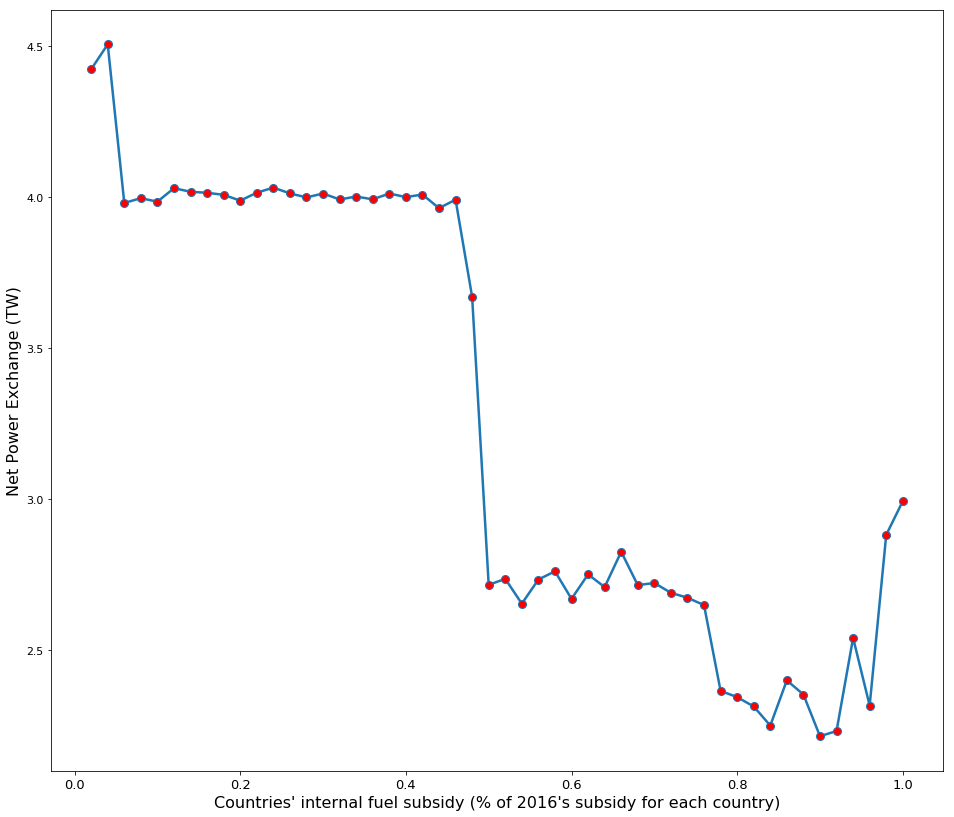

In [41]:
plt.plot(LocalSubsidyMultipliers,np.array(NetPowerExchange)/1000000, linewidth=2.5, marker='o',markersize=8,markerfacecolor="r")
plt.xlabel("Countries' internal fuel subsidy (% of 2016's subsidy for each country)", fontsize=16)
plt.ylabel('Net Power Exchange (TW)', fontsize=16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=11)
plt.savefig('../../../../../../../../../Desktop/Net Power Exchange.png',dpi=300,tight_layout='tight_box')


In [42]:
NetPowerFlow = []
LocalSubsidyMultipliers = []
for i in np.arange(1, 0, -0.02):
    LocalSubsidyMultiplier=i
    ExportCostMultiplier=1
    NetPowerFlow.append(FindNetPowerFlow(Results_dic['LocalSubsidyMultiplier: '+str(LocalSubsidyMultiplier)+' & ExportCostMultiplier: '+str(ExportCostMultiplier)]['PowerFlow']).abs().sum().sum())
    LocalSubsidyMultipliers.append(LocalSubsidyMultiplier)
    

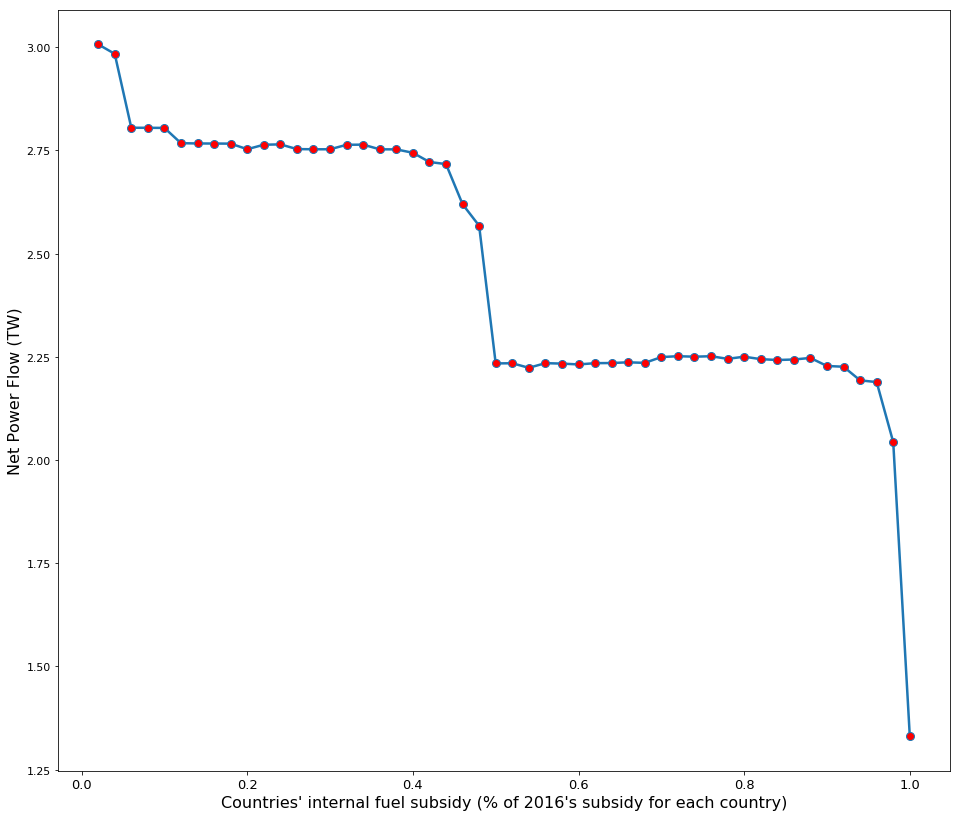

In [43]:
plt.plot(LocalSubsidyMultipliers,np.array(NetPowerFlow)/1000000, linewidth=2.5, marker='o',markersize=8,markerfacecolor="r")
plt.xlabel("Countries' internal fuel subsidy (% of 2016's subsidy for each country)", fontsize=16)
plt.ylabel('Net Power Flow (TW)', fontsize=16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=11)
plt.savefig('../../../../../../../../../Desktop/Net Power Flow.png',dpi=300,tight_layout='tight_box')


In [44]:
TotalPowerExchange = []
LocalSubsidyMultipliers = []
for i in np.arange(1, 0, -0.02):
    LocalSubsidyMultiplier=i
    ExportCostMultiplier=1
    TotalPowerExchange.append(Results_dic['LocalSubsidyMultiplier: '+str(LocalSubsidyMultiplier)+' & ExportCostMultiplier: '+str(ExportCostMultiplier)]['ExportedPowerToNode'].abs().sum().sum())
    LocalSubsidyMultipliers.append(LocalSubsidyMultiplier)
    

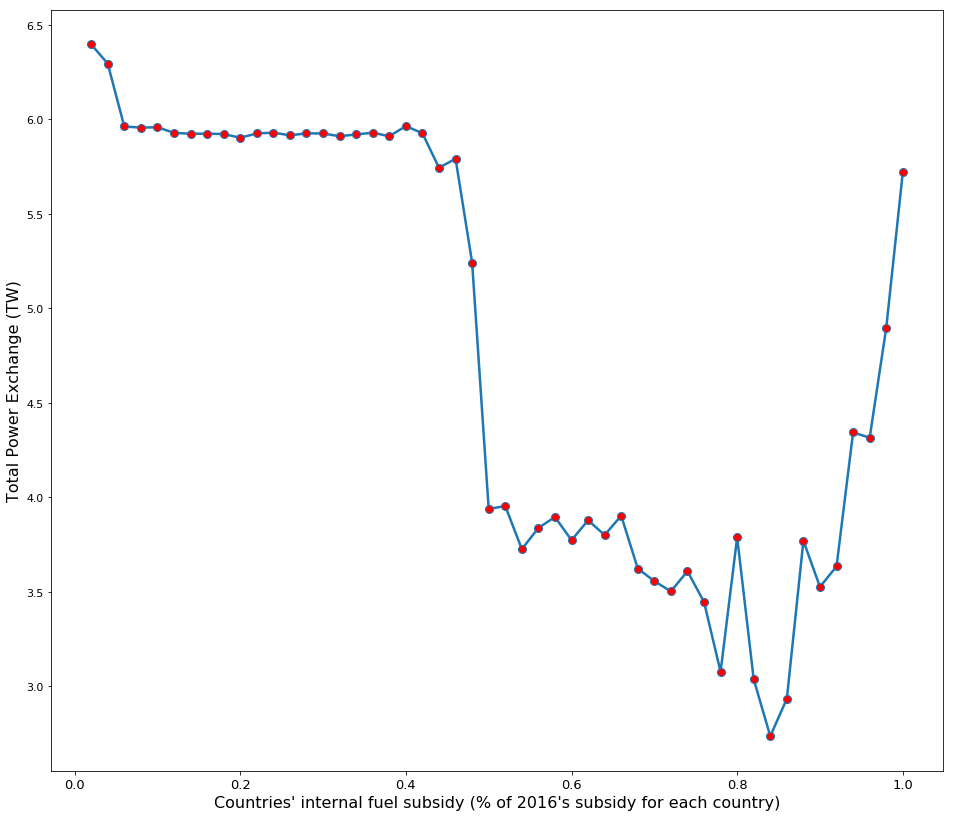

In [45]:
plt.plot(LocalSubsidyMultipliers,np.array(TotalPowerExchange)/1000000, linewidth=2.5, marker='o',markersize=8,markerfacecolor="r")
plt.xlabel("Countries' internal fuel subsidy (% of 2016's subsidy for each country)", fontsize=16)
plt.ylabel('Total Power Exchange (TW)', fontsize=16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=11)
plt.savefig('../../../../../../../../../Desktop/Total Power Exchange.png',dpi=300,tight_layout='tight_box')


In [138]:
TotalSystemCost = []
LocalSubsidyMultipliers = []
for i in np.arange(1, 0, -0.02):
    LocalSubsidyMultiplier=i
    ExportCostMultiplier=1
    TotalSystemCost.append(Results_dic['LocalSubsidyMultiplier: '+str(LocalSubsidyMultiplier)+' & ExportCostMultiplier: '+str(ExportCostMultiplier)]['TotalSystemCost'].sum())
    LocalSubsidyMultipliers.append(LocalSubsidyMultiplier)


(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.,
        1800.]), <a list of 10 Text yticklabel objects>)

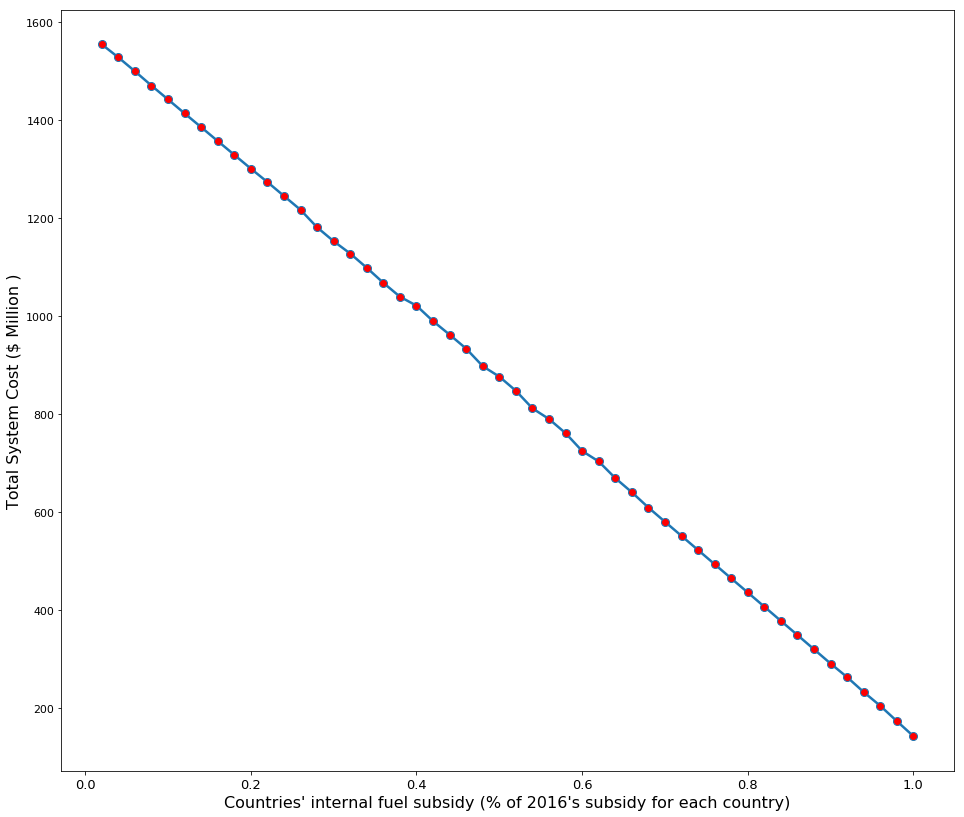

In [139]:
plt.plot(LocalSubsidyMultipliers,np.array(TotalSystemCost)/1000000, linewidth=2.5, marker='o',markersize=8,markerfacecolor="r")
plt.xlabel("Countries' internal fuel subsidy (% of 2016's subsidy for each country)", fontsize=16)
plt.ylabel('Total System Cost ($ Million )', fontsize=16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=11)


In [46]:
ZoneCost = []
LocalSubsidyMultipliers = []
for i in np.arange(1, 0, -0.02):
    LocalSubsidyMultiplier=i
    ExportCostMultiplier=1
    NodeCost = Results_dic['LocalSubsidyMultiplier: '+str(LocalSubsidyMultiplier)+' & ExportCostMultiplier: '+str(ExportCostMultiplier)]['TotalNodeOperationCost'].copy() 
    NodeCost = AddKSACountry(NodeCost, Operation='sum')
    ZoneCost.append(NodeCost.sum())
    LocalSubsidyMultipliers.append(LocalSubsidyMultiplier)


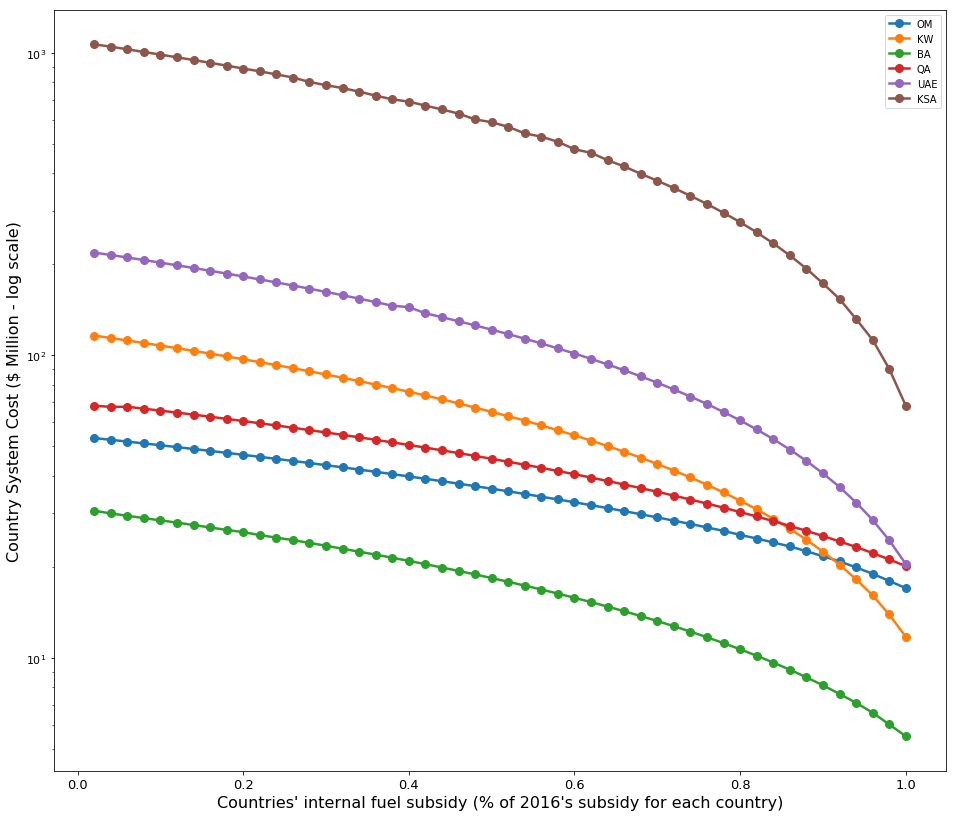

In [404]:
plt.plot(LocalSubsidyMultipliers,np.array(ZoneCost)/1000000, linewidth=2.5, marker='o', markersize=8)
plt.xlabel("Countries' internal fuel subsidy (% of 2016's subsidy for each country)", fontsize=16)
plt.ylabel('Country System Cost ($ Million - log scale)', fontsize=16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=11)
plt.yscale('log')
plt.gca().legend(list(ZoneCost[0].index.values))


In [47]:
ZoneCost = []
LocalSubsidyMultipliers = []
for i in np.arange(1, 0, -0.02):
    LocalSubsidyMultiplier=i
    ExportCostMultiplier=1
    NodeCost = Results_dic['LocalSubsidyMultiplier: '+str(LocalSubsidyMultiplier)+' & ExportCostMultiplier: '+str(ExportCostMultiplier)]['TotalNodeOperationCost'].copy() 
    NodeCost = AddKSACountry(NodeCost, Operation='sum')
    SystemCost = Results_dic['LocalSubsidyMultiplier: '+str(LocalSubsidyMultiplier)+' & ExportCostMultiplier: '+str(ExportCostMultiplier)]['TotalSystemCost'].sum()
    ZoneCost.append(NodeCost.sum()/SystemCost)
    LocalSubsidyMultipliers.append(LocalSubsidyMultiplier)


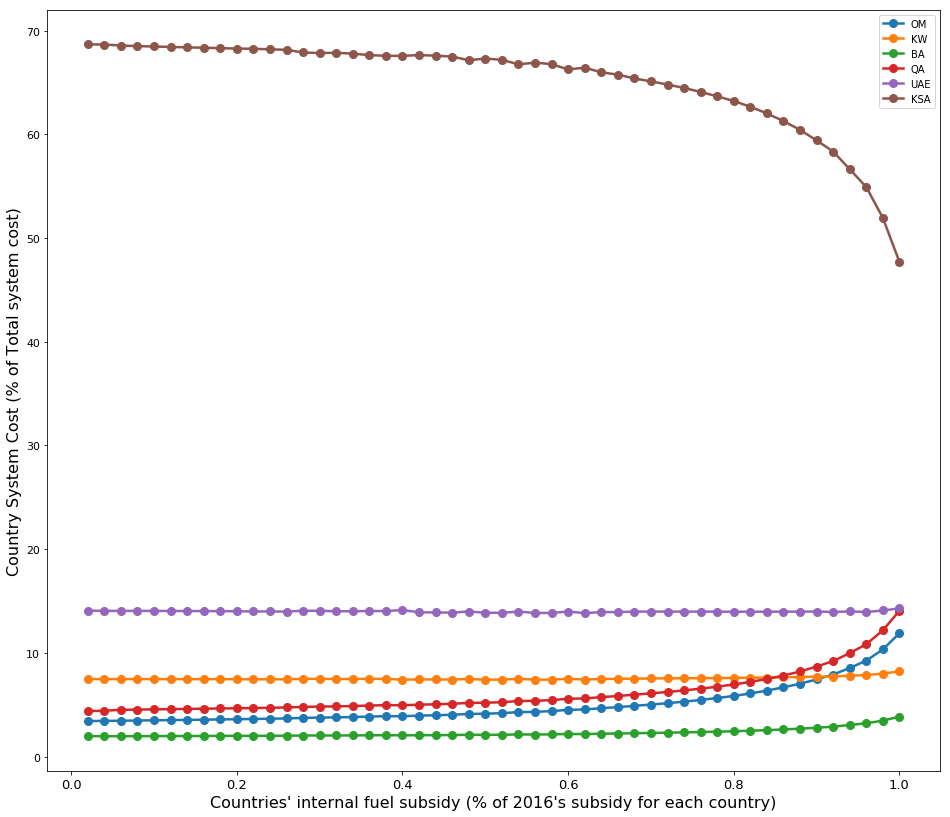

In [52]:
plt.plot(LocalSubsidyMultipliers,np.array(ZoneCost)*100, linewidth=2.5, marker='o', markersize=8)
plt.xlabel("Countries' internal fuel subsidy (% of 2016's subsidy for each country)", fontsize=16)
plt.ylabel('Country System Cost (% of Total system cost)', fontsize=16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=11)
#plt.yscale('log')
plt.gca().legend(list(ZoneCost[0].index.values))
plt.savefig('../../../../../../../../../Desktop/Country System Cost.png',dpi=300,tight_layout='tight_box')


In [53]:
ZoneShadowPrice = []
LocalSubsidyMultipliers = []
for i in np.arange(1, 0, -0.02):
    LocalSubsidyMultiplier=i
    ExportCostMultiplier=1
    NodeShadowPrice = Results_dic['LocalSubsidyMultiplier: '+str(LocalSubsidyMultiplier)+' & ExportCostMultiplier: '+str(ExportCostMultiplier)]['NodeShadowPrice'].copy() 
    NodeShadowPrice = AddKSACountry(NodeShadowPrice, Operation='mean')
    if (NodeShadowPrice.mean()<=300).eq(True).all():
        ZoneShadowPrice.append(NodeShadowPrice.mean())
    else:
        pass

    if (NodeShadowPrice.mean()<=300).eq(True).all():
        LocalSubsidyMultipliers.append(LocalSubsidyMultiplier)
    else:
        pass


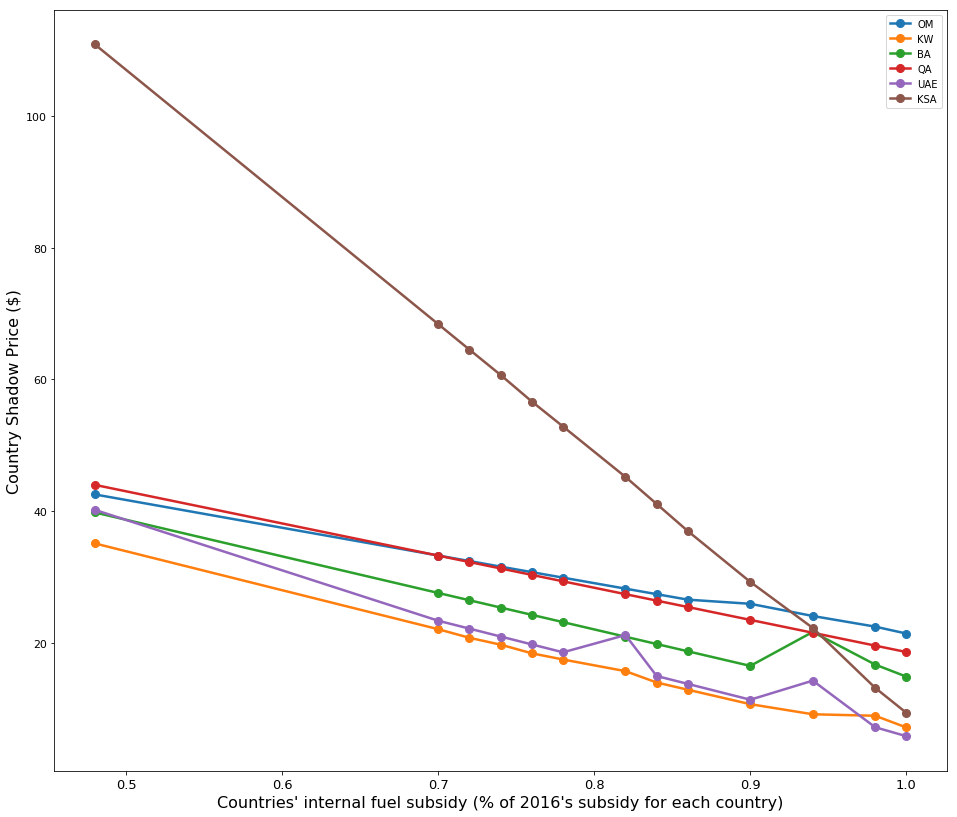

In [56]:
plt.plot(LocalSubsidyMultipliers,np.array(ZoneShadowPrice), linewidth=2.5, marker='o', markersize=8)
plt.xlabel("Countries' internal fuel subsidy (% of 2016's subsidy for each country)", fontsize=16)
plt.ylabel('Country Shadow Price ($)', fontsize=16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=11)
#plt.yscale('log')
plt.gca().legend(list(ZoneCost[0].index.values))
#plt.savefig('../../../../../../../../../Desktop/Country Shadow Price.png',dpi=300,tight_layout='tight_box')


In [64]:
ZoneShadowPrice = []
LocalSubsidyMultipliers = []
for i in np.arange(1, 0, -0.02):
    LocalSubsidyMultiplier=i
    ExportCostMultiplier=1
    NodeShadowPrice = Results_dic['LocalSubsidyMultiplier: '+str(LocalSubsidyMultiplier)+' & ExportCostMultiplier: '+str(ExportCostMultiplier)]['NodeShadowPrice'].copy() 
    NodeShadowPrice = AddKSACountry(NodeShadowPrice, Operation='mean')
    SystemCost = Results_dic['LocalSubsidyMultiplier: '+str(LocalSubsidyMultiplier)+' & ExportCostMultiplier: '+str(ExportCostMultiplier)]['TotalSystemCost'].sum()
    if (NodeShadowPrice.mean()<=300).eq(True).all():
        ZoneShadowPrice.append(NodeShadowPrice.mean()/(SystemCost/1000000))
    else:
        pass

    if (NodeShadowPrice.mean()<=300).eq(True).all():
        LocalSubsidyMultipliers.append(LocalSubsidyMultiplier)
    else:
        pass


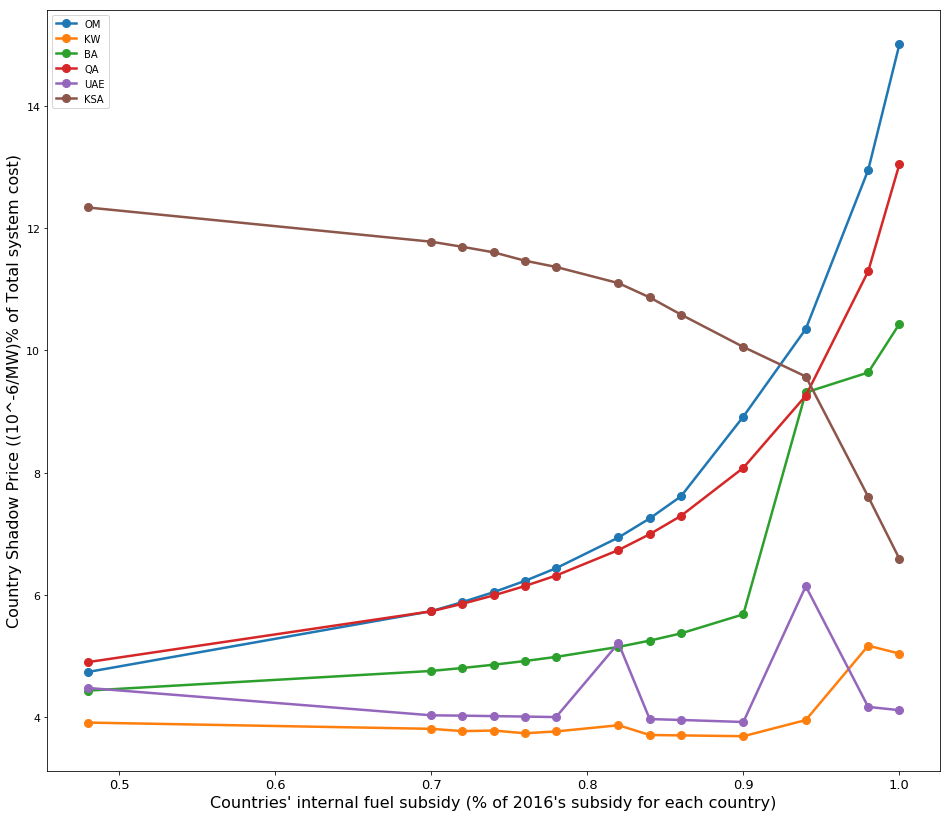

In [68]:
plt.plot(LocalSubsidyMultipliers,np.array(ZoneShadowPrice)*100, linewidth=2.5, marker='o', markersize=8)
plt.xlabel("Countries' internal fuel subsidy (% of 2016's subsidy for each country)", fontsize=16)
plt.ylabel('Country Shadow Price ((10^-6/MW)% of Total system cost)', fontsize=16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=11)
#plt.yscale('log')
plt.gca().legend(list(ZoneCost[0].index.values))
plt.savefig('../../../../../../../../../Desktop/Country Shadow Price.png',dpi=300,tight_layout='tight_box')


In [429]:
AverageElectricityCosts = []
LocalSubsidyMultipliers = []
for i in np.arange(1, 0, -0.02):
    LocalSubsidyMultiplier=i
    ExportCostMultiplier=1
    AverageElectricityCost = FindAverageElectricityCostPlusKSA(Inputs_dic['LocalSubsidyMultiplier: '+str(LocalSubsidyMultiplier)+' & ExportCostMultiplier: '+str(ExportCostMultiplier)]['Demand']['DA'],Results_dic['LocalSubsidyMultiplier: '+str(LocalSubsidyMultiplier)+' & ExportCostMultiplier: '+str(ExportCostMultiplier)]['TotalNodeOperationCost'],DropKSAZones=True)
    AverageElectricityCosts.append(AverageElectricityCost)
    LocalSubsidyMultipliers.append(LocalSubsidyMultiplier)


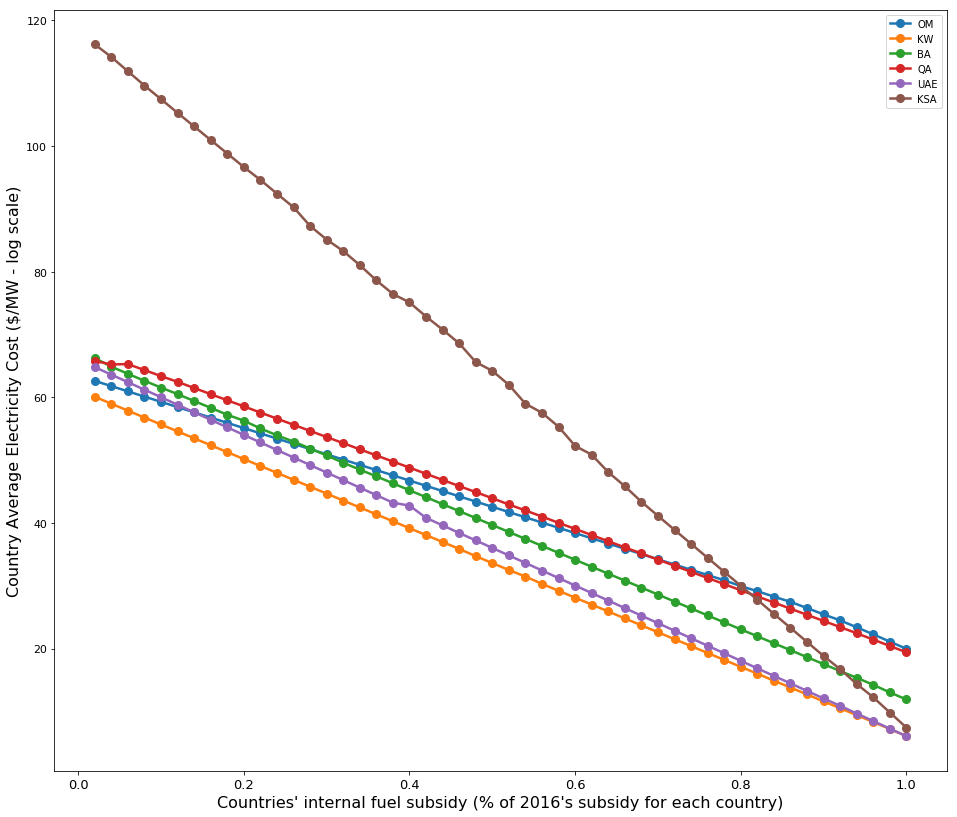

In [358]:
plt.plot(LocalSubsidyMultipliers,np.array(AverageElectricityCosts), linewidth=2.5, marker='o', markersize=8)
plt.xlabel("Countries' internal fuel subsidy (% of 2016's subsidy for each country)", fontsize=16)
plt.ylabel('Country Average Electricity Cost ($/MW - log scale)', fontsize=16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=11)
#plt.yscale('log')
plt.gca().legend(list(ZoneCost[0].index.values))



In [70]:
AverageElectricityCosts = []
LocalSubsidyMultipliers = []
for i in np.arange(1, 0, -0.02):
    LocalSubsidyMultiplier=i
    ExportCostMultiplier=1
    AverageElectricityCost = FindAverageElectricityCostPlusKSA(Inputs_dic_DF['LocalSubsidyMultiplier: '+str(LocalSubsidyMultiplier)+' & ExportCostMultiplier: '+str(ExportCostMultiplier)]['Demand']['DA'],Results_dic['LocalSubsidyMultiplier: '+str(LocalSubsidyMultiplier)+' & ExportCostMultiplier: '+str(ExportCostMultiplier)]['TotalNodeOperationCost'],DropKSAZones=True)
    SystemCost = Results_dic['LocalSubsidyMultiplier: '+str(LocalSubsidyMultiplier)+' & ExportCostMultiplier: '+str(ExportCostMultiplier)]['TotalSystemCost'].sum()
    AverageElectricityCosts.append(AverageElectricityCost/(SystemCost/1000000))
    LocalSubsidyMultipliers.append(LocalSubsidyMultiplier)


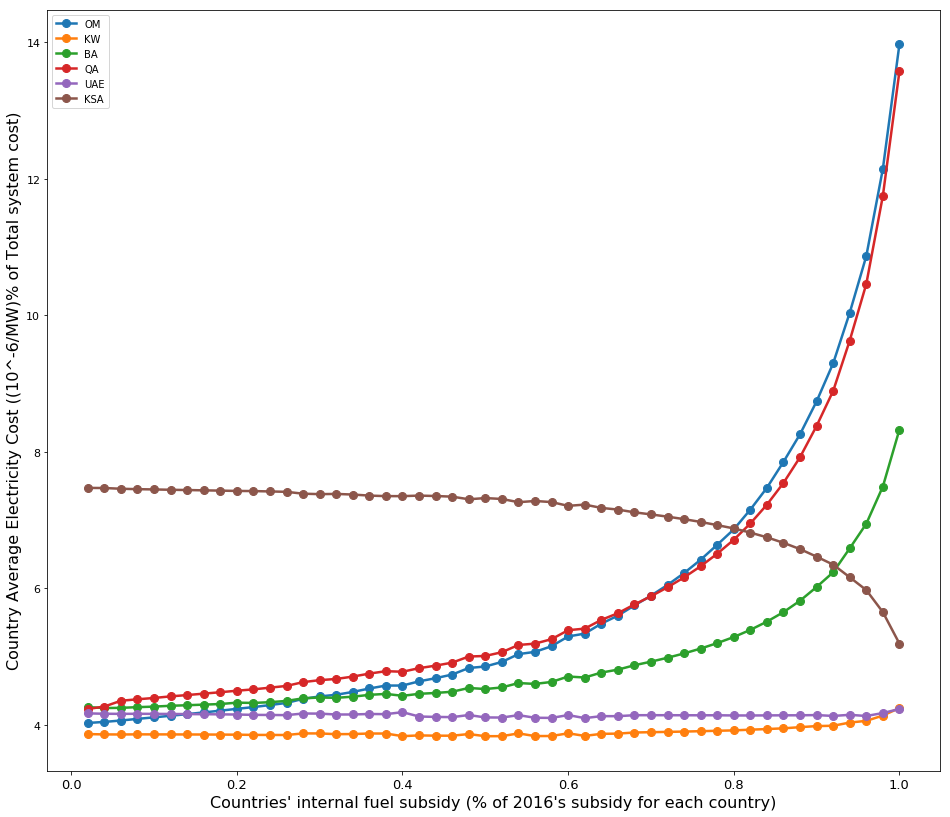

In [79]:
plt.plot(LocalSubsidyMultipliers,np.array(AverageElectricityCosts)*100, linewidth=2.5, marker='o', markersize=8)
plt.xlabel("Countries' internal fuel subsidy (% of 2016's subsidy for each country)", fontsize=16)
plt.ylabel('Country Average Electricity Cost ((10^-6/MW)% of Total system cost)', fontsize=16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=11)
#plt.yscale('log')
plt.gca().legend(list(ZoneCost[0].index.values))
plt.savefig('../../../../../../../../../Desktop/Country Average Electricity Cost.png',dpi=300,tight_layout='tight_box')


In [385]:
ElectricityNodePrices1 = []
LocalSubsidyMultipliers = []
for i in np.arange(1, 0, -0.02):
    LocalSubsidyMultiplier=i
    ExportCostMultiplier=1
    ElectricityNodePrice = AddKSACountry(Results_dic['LocalSubsidyMultiplier: '+str(LocalSubsidyMultiplier)+' & ExportCostMultiplier: '+str(ExportCostMultiplier)]['ElectricityNodePrice'],Operation='mean')
    ElectricityNodePrice = ElectricityNodePrice.mean()
    ElectricityNodePrices1.append(ElectricityNodePrice)
    LocalSubsidyMultipliers.append(LocalSubsidyMultiplier)


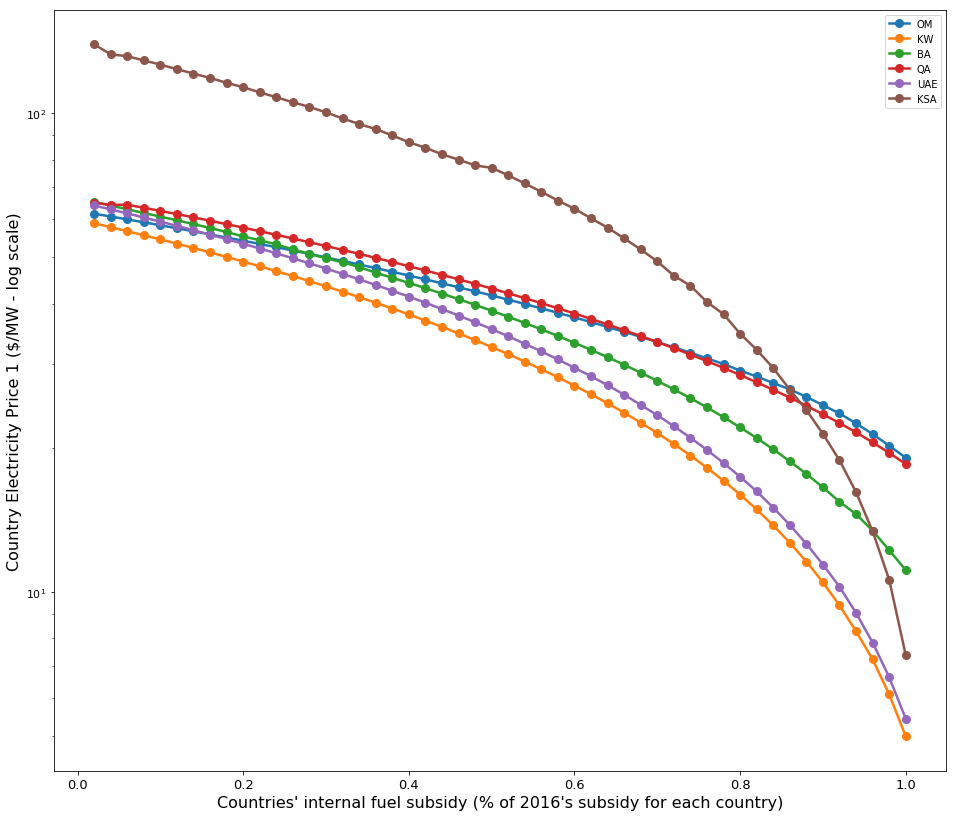

In [386]:
plt.plot(LocalSubsidyMultipliers,np.array(ElectricityNodePrices1), linewidth=2.5, marker='o', markersize=8)
plt.xlabel("Countries' internal fuel subsidy (% of 2016's subsidy for each country)", fontsize=16)
plt.ylabel('Country Electricity Price 1 ($/MW - log scale)', fontsize=16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=11)
plt.yscale('log')
plt.gca().legend(list(ZoneCost[0].index.values))



In [80]:
ElectricityNodePrices1 = []
LocalSubsidyMultipliers = []
for i in np.arange(1, 0, -0.02):
    LocalSubsidyMultiplier=i
    ExportCostMultiplier=1
    LocalSubsidyMultiplier=i
    ExportCostMultiplier=1
    ElectricityNodePrice = AddKSACountry(Results_dic['LocalSubsidyMultiplier: '+str(LocalSubsidyMultiplier)+' & ExportCostMultiplier: '+str(ExportCostMultiplier)]['ElectricityNodePrice'],Operation='mean')
    ElectricityNodePrice = ElectricityNodePrice.mean()
    SystemCost = Results_dic['LocalSubsidyMultiplier: '+str(LocalSubsidyMultiplier)+' & ExportCostMultiplier: '+str(ExportCostMultiplier)]['TotalSystemCost'].sum()
    ElectricityNodePrices1.append(AverageElectricityCost/(SystemCost/1000000))
    LocalSubsidyMultipliers.append(LocalSubsidyMultiplier)



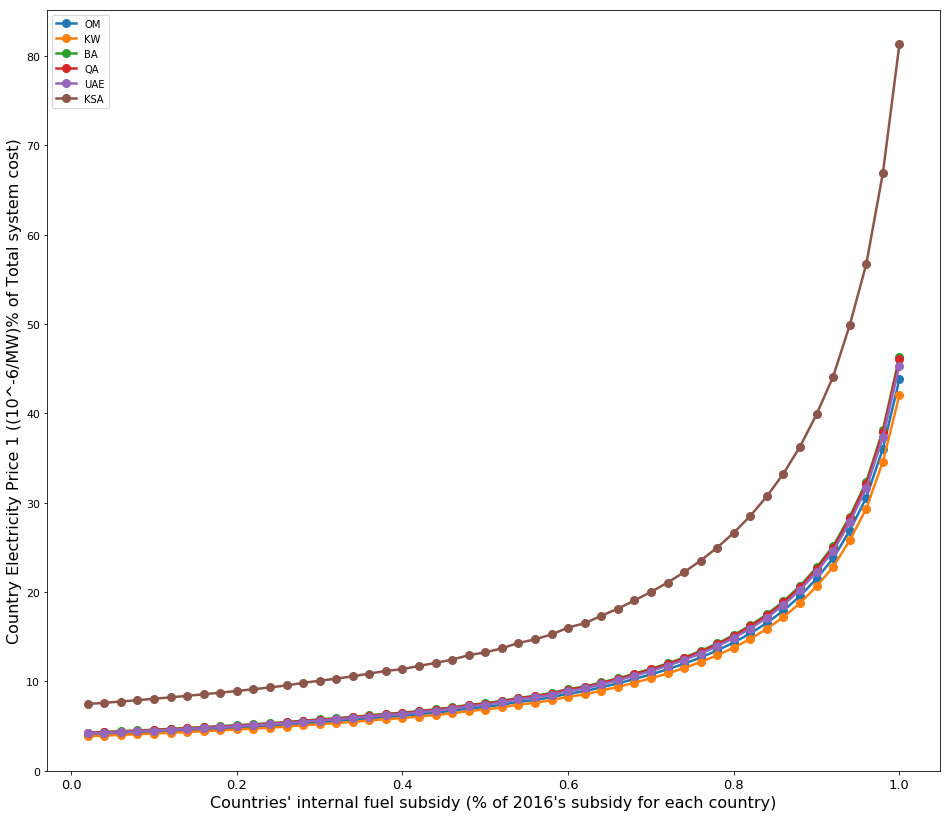

In [82]:
plt.plot(LocalSubsidyMultipliers,np.array(ElectricityNodePrices1)*100, linewidth=2.5, marker='o', markersize=8)
plt.xlabel("Countries' internal fuel subsidy (% of 2016's subsidy for each country)", fontsize=16)
plt.ylabel('Country Electricity Price 1 ((10^-6/MW)% of Total system cost)', fontsize=16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=11)
#plt.yscale('log')
plt.gca().legend(list(ZoneCost[0].index.values))
plt.savefig('../../../../../../../../../Desktop/Country Electricity Price 1.png',dpi=300,tight_layout='tight_box')


In [392]:
ElectricityNodePrices2 = []
LocalSubsidyMultipliers = []
for i in np.arange(1, 0, -0.02):
    LocalSubsidyMultiplier=i
    ExportCostMultiplier=1
    ElectricityNodePrice = AddKSACountry(Results_dic['LocalSubsidyMultiplier: '+str(LocalSubsidyMultiplier)+' & ExportCostMultiplier: '+str(ExportCostMultiplier)]['ElectricityNodePrice2'],Operation='mean')
    ElectricityNodePrice = ElectricityNodePrice.mean()
    ElectricityNodePrices2.append(ElectricityNodePrice)
    LocalSubsidyMultipliers.append(LocalSubsidyMultiplier)


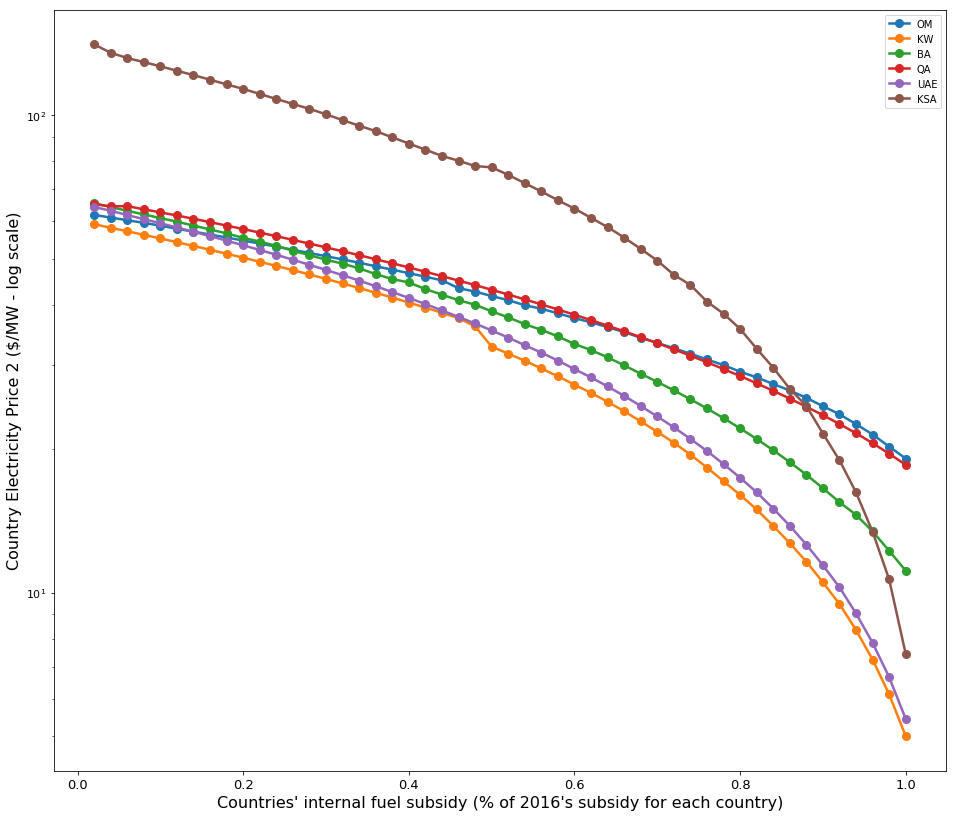

In [393]:
plt.plot(LocalSubsidyMultipliers,np.array(ElectricityNodePrices2), linewidth=2.5, marker='o', markersize=8)
plt.xlabel("Countries' internal fuel subsidy (% of 2016's subsidy for each country)", fontsize=16)
plt.ylabel('Country Electricity Price 2 ($/MW - log scale)', fontsize=16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=11)
plt.yscale('log')
plt.gca().legend(list(ZoneCost[0].index.values))




In [83]:
ElectricityNodePrices2 = []
LocalSubsidyMultipliers = []
for i in np.arange(1, 0, -0.02):
    LocalSubsidyMultiplier=i
    ExportCostMultiplier=1
    LocalSubsidyMultiplier=i
    ExportCostMultiplier=1
    ElectricityNodePrice = AddKSACountry(Results_dic['LocalSubsidyMultiplier: '+str(LocalSubsidyMultiplier)+' & ExportCostMultiplier: '+str(ExportCostMultiplier)]['ElectricityNodePrice2'],Operation='mean')
    ElectricityNodePrice = ElectricityNodePrice.mean()
    SystemCost = Results_dic['LocalSubsidyMultiplier: '+str(LocalSubsidyMultiplier)+' & ExportCostMultiplier: '+str(ExportCostMultiplier)]['TotalSystemCost'].sum()
    ElectricityNodePrices2.append(AverageElectricityCost/(SystemCost/1000000))
    LocalSubsidyMultipliers.append(LocalSubsidyMultiplier)


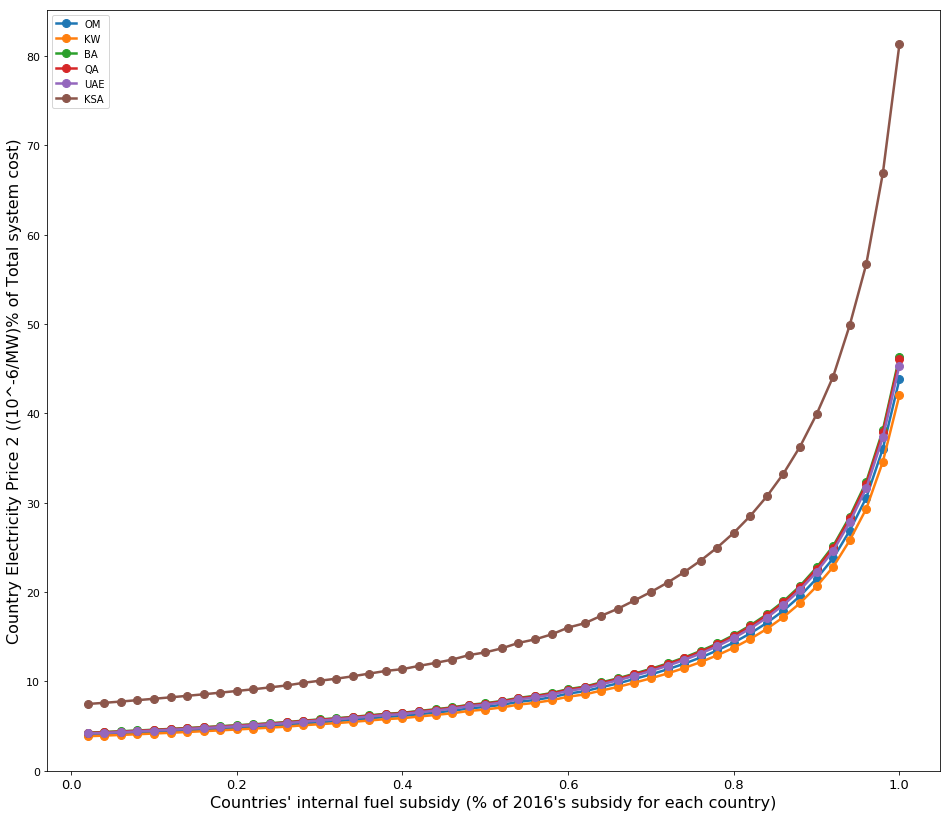

In [86]:
plt.plot(LocalSubsidyMultipliers,np.array(ElectricityNodePrices2)*100, linewidth=2.5, marker='o', markersize=8)
plt.xlabel("Countries' internal fuel subsidy (% of 2016's subsidy for each country)", fontsize=16)
plt.ylabel('Country Electricity Price 2 ((10^-6/MW)% of Total system cost)', fontsize=16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=11)
#plt.yscale('log')
plt.gca().legend(list(ZoneCost[0].index.values))
plt.savefig('../../../../../../../../../Desktop/Country Electricity Price 2.png',dpi=300,tight_layout='tight_box')





In [396]:
ElectricityNodePrices3 = []
LocalSubsidyMultipliers = []
for i in np.arange(1, 0, -0.02):
    LocalSubsidyMultiplier=i
    ExportCostMultiplier=1
    ElectricityNodePrice = AddKSACountry(Results_dic['LocalSubsidyMultiplier: '+str(LocalSubsidyMultiplier)+' & ExportCostMultiplier: '+str(ExportCostMultiplier)]['ElectricityNodePrice3'],Operation='mean')
    ElectricityNodePrice = ElectricityNodePrice.mean()
    ElectricityNodePrices3.append(ElectricityNodePrice)
    LocalSubsidyMultipliers.append(LocalSubsidyMultiplier)


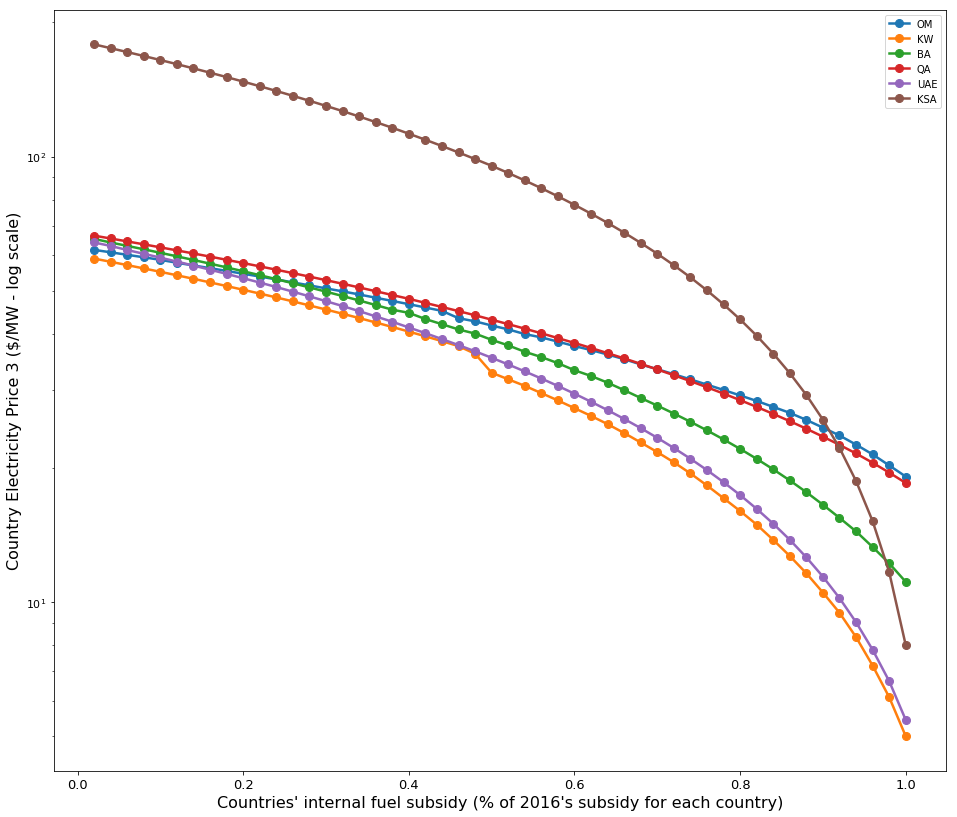

In [397]:
plt.plot(LocalSubsidyMultipliers,np.array(ElectricityNodePrices3), linewidth=2.5, marker='o', markersize=8)
plt.xlabel("Countries' internal fuel subsidy (% of 2016's subsidy for each country)", fontsize=16)
plt.ylabel('Country Electricity Price 3 ($/MW - log scale)', fontsize=16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=11)
plt.yscale('log')
plt.gca().legend(list(ZoneCost[0].index.values))


In [87]:
ElectricityNodePrices3 = []
LocalSubsidyMultipliers = []
for i in np.arange(1, 0, -0.02):
    LocalSubsidyMultiplier=i
    ExportCostMultiplier=1
    LocalSubsidyMultiplier=i
    ExportCostMultiplier=1
    ElectricityNodePrice = AddKSACountry(Results_dic['LocalSubsidyMultiplier: '+str(LocalSubsidyMultiplier)+' & ExportCostMultiplier: '+str(ExportCostMultiplier)]['ElectricityNodePrice3'],Operation='mean')
    ElectricityNodePrice = ElectricityNodePrice.mean()
    SystemCost = Results_dic['LocalSubsidyMultiplier: '+str(LocalSubsidyMultiplier)+' & ExportCostMultiplier: '+str(ExportCostMultiplier)]['TotalSystemCost'].sum()
    ElectricityNodePrices3.append(AverageElectricityCost/(SystemCost/1000000))
    LocalSubsidyMultipliers.append(LocalSubsidyMultiplier)


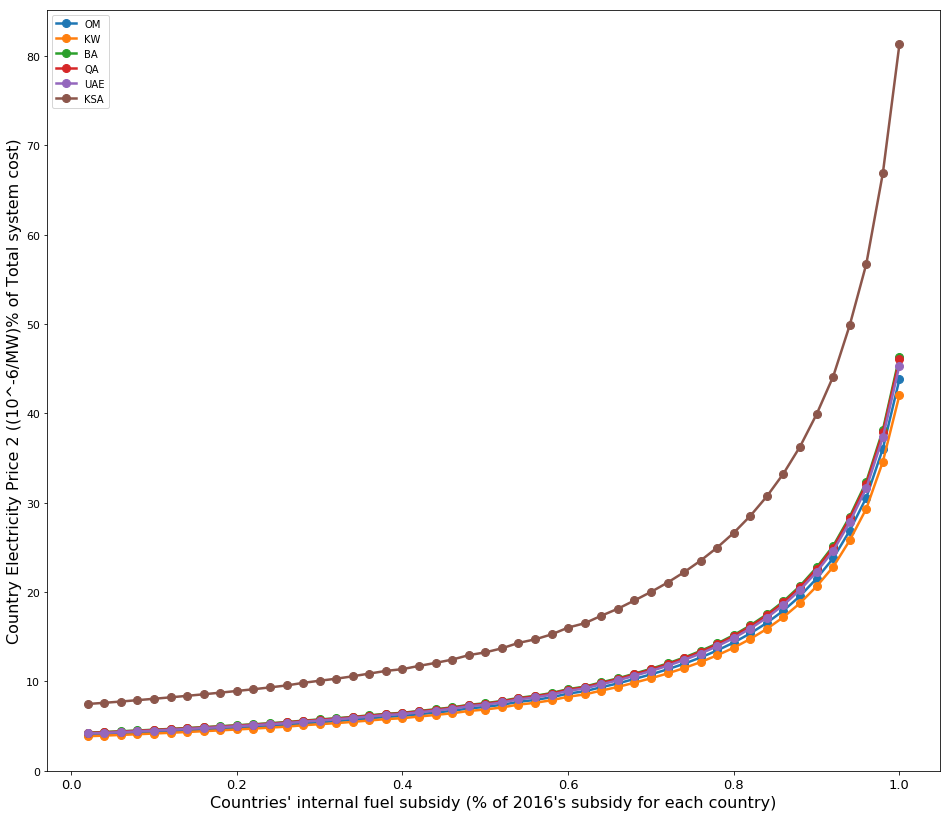

In [89]:
plt.plot(LocalSubsidyMultipliers,np.array(ElectricityNodePrices3)*100, linewidth=2.5, marker='o', markersize=8)
plt.xlabel("Countries' internal fuel subsidy (% of 2016's subsidy for each country)", fontsize=16)
plt.ylabel('Country Electricity Price 2 ((10^-6/MW)% of Total system cost)', fontsize=16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=11)
#plt.yscale('log')
plt.gca().legend(list(ZoneCost[0].index.values))
plt.savefig('../../../../../../../../../Desktop/Country Electricity Price 3.png',dpi=300,tight_layout='tight_box')



In [20]:
PPindicators = post.get_indicators_powerplant(inputs,results)

fuels = PPindicators.Fuel.unique()
countries = PPindicators.Zone.unique()

GenPerCountry = pd.DataFrame(index=countries, columns=fuels)
# First make sure that all fuels are present. If not, initialize an empty series
for f in ['NUC', 'LFG', 'DSL', 'MSW', 'GAS', 'OIL', 'WST', 'SUN', 'WIN', 'FlowIn', 'HFO']:
    if f not in GenPerCountry:
        GenPerCountry[f] = 0
for c in countries:
    for f in fuels:
        tmp = PPindicators[(PPindicators.Fuel == f) & (PPindicators.Zone == c)]
        GenPerCountry.loc[c, f] = tmp.Generation.sum()
    NetImports = post.get_imports(results['PowerFlow'], c)
    if NetImports > 0:
        GenPerCountry.loc[c, 'FlowIn'] = NetImports
GenPerCountry = GenPerCountry.copy()
A = GenPerCountry.drop(['BA','KW','OM','QA','UAE']).sum()
A.name = 'KSA'
GenPerCountry = GenPerCountry.append(A, ignore_index=False)

In [32]:
results['NodeFuelCost'].sum()/1000000

SA_EOA     GAS    293.317141
SA_RIYADH  GAS     53.523912
           OIL    288.351831
SA_QASSIM  OIL      3.703649
SA_HAIL    OIL     29.533966
SA_WOA     GAS     31.417267
           OIL     95.975736
           HFO    226.082123
SA_SOA     GAS     32.020334
           OIL     43.599002
           DSL    136.000856
SA_NWOA    OIL     34.857634
           DSL      2.376581
SA_NEOA    OIL      6.140355
           DSL     15.506438
OM         GAS     46.833517
           OIL     17.391452
KW         GAS    115.626316
           OIL      2.157542
BA         GAS     30.812611
QA         GAS     68.969286
           OIL      2.740982
UAE        GAS    221.372372
           OIL      0.101171
           LFG      0.029215
dtype: float64

### Read inputs from multiple simulations

In [48]:
Inputs_dic['LocalSubsidyMultiplier: 1.0 & ExportCostMultiplier: 1'].keys()

dict_keys(['sets', 'AvailabilityFactor', 'CHPPowerToHeat', 'CHPPowerLossFactor', 'CHPMaxHeat', 'CostFixed', 'CostHeatSlack', 'CostLoadShedding', 'CostRampUp', 'CostRampDown', 'CostShutDown', 'CostStartUp', 'CostVariable', 'CostVariableB', 'Curtailment', 'Demand', 'Efficiency', 'EmissionMaximum', 'EmissionRate', 'FlowMaximum', 'FlowMinimum', 'FuelPrice', 'Fuel', 'HeatDemand', 'LineNode', 'LoadShedding', 'Location', 'Markup', 'Nunits', 'OutageFactor', 'PartLoadMin', 'PowerCapacity', 'PowerInitial', 'PriceTransmission', 'RampUpMaximum', 'RampDownMaximum', 'RampStartUpMaximum', 'RampShutDownMaximum', 'Reserve', 'StorageCapacity', 'StorageChargingCapacity', 'StorageChargingEfficiency', 'StorageDischargeEfficiency', 'StorageSelfDischarge', 'StorageInflow', 'StorageInitial', 'StorageMinimum', 'StorageOutflow', 'StorageProfile', 'Technology', 'TimeUpMinimum', 'TimeDownMinimum', 'Config', 'FuelPricePerZone'])

In [434]:
Inputs_dic['LocalSubsidyMultiplier: 1.0 & ExportCostMultiplier: 1']['Nunits']

,Nunits
"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11] - SA_EOA - STUR - GAS -",12
"[12, 13, 14, 15, 16, ... _EOA - GTUR - GAS -",81
"[30, 31, 32, 33, 34, 35] - SA_EOA - COMC - GAS -",6
"[58, 59, 60, 61, 62, 63] - SA_EOA - GTUR - DSL -",6
"[105, 106, 107, 108, ... _EOA - ICEN - GAS -",8
[113] - Saudi Aramco North Park Project,1
"[114, 115, 116, 117, ... HAIL - GTUR - OIL -",12
"[126, 127, 128, 129, ... NEOA - GTUR - OIL -",10
"[136, 137, 138, 139, ... NEOA - GTUR - DSL -",10
"[146, 151] - SA_NWOA - GTUR - DSL -",2


In [14]:
FuelPrices_dic.keys()


dict_keys(['LocalSubsidyMultiplier: 1.0 & ExportCostMultiplier: 1 & FuelPrices 1', 'LocalSubsidyMultiplier: 1.0 & ExportCostMultiplier: 1 & FuelPrices 2', 'LocalSubsidyMultiplier: 0.98 & ExportCostMultiplier: 1 & FuelPrices 1', 'LocalSubsidyMultiplier: 0.98 & ExportCostMultiplier: 1 & FuelPrices 2', 'LocalSubsidyMultiplier: 0.96 & ExportCostMultiplier: 1 & FuelPrices 1', 'LocalSubsidyMultiplier: 0.96 & ExportCostMultiplier: 1 & FuelPrices 2', 'LocalSubsidyMultiplier: 0.94 & ExportCostMultiplier: 1 & FuelPrices 1', 'LocalSubsidyMultiplier: 0.94 & ExportCostMultiplier: 1 & FuelPrices 2', 'LocalSubsidyMultiplier: 0.9199999999999999 & ExportCostMultiplier: 1 & FuelPrices 1', 'LocalSubsidyMultiplier: 0.9199999999999999 & ExportCostMultiplier: 1 & FuelPrices 2'])

In [26]:
FuelPrices_dic['LocalSubsidyMultiplier: 1.0 & ExportCostMultiplier: 1 & FuelPrices 1']

,SA_EOA,SA_RIYADH,SA_QASSIM,SA_HAIL,SA_WOA,SA_SOA,SA_NWOA,SA_NEOA,OM,KW,...,SA_HAIL,SA_WOA,SA_SOA,SA_NWOA,SA_NEOA,OM,KW,BA,QA,UAE
,PriceOfGas,PriceOfGas,PriceOfGas,PriceOfGas,PriceOfGas,PriceOfGas,PriceOfGas,PriceOfGas,PriceOfGas,PriceOfGas,...,PriceOfLandFillGas,PriceOfLandFillGas,PriceOfLandFillGas,PriceOfLandFillGas,PriceOfLandFillGas,PriceOfLandFillGas,PriceOfLandFillGas,PriceOfLandFillGas,PriceOfLandFillGas,PriceOfLandFillGas
2016-07-10 23:00:00,2.557133,2.557133,2.557133,2.557133,2.557133,2.557133,2.557133,2.557133,10.228532,2.557133,...,40.936596,40.936596,40.936596,40.936596,40.936596,40.936596,40.936596,40.936596,40.936596,40.936596
2016-07-11 00:00:00,2.557133,2.557133,2.557133,2.557133,2.557133,2.557133,2.557133,2.557133,10.228532,2.557133,...,40.936596,40.936596,40.936596,40.936596,40.936596,40.936596,40.936596,40.936596,40.936596,40.936596
2016-07-11 01:00:00,2.557133,2.557133,2.557133,2.557133,2.557133,2.557133,2.557133,2.557133,10.228532,2.557133,...,40.936596,40.936596,40.936596,40.936596,40.936596,40.936596,40.936596,40.936596,40.936596,40.936596
2016-07-11 02:00:00,2.557133,2.557133,2.557133,2.557133,2.557133,2.557133,2.557133,2.557133,10.228532,2.557133,...,40.936596,40.936596,40.936596,40.936596,40.936596,40.936596,40.936596,40.936596,40.936596,40.936596
2016-07-11 03:00:00,2.557133,2.557133,2.557133,2.557133,2.557133,2.557133,2.557133,2.557133,10.228532,2.557133,...,40.936596,40.936596,40.936596,40.936596,40.936596,40.936596,40.936596,40.936596,40.936596,40.936596
2016-07-11 04:00:00,2.557133,2.557133,2.557133,2.557133,2.557133,2.557133,2.557133,2.557133,10.228532,2.557133,...,40.936596,40.936596,40.936596,40.936596,40.936596,40.936596,40.936596,40.936596,40.936596,40.936596
2016-07-11 05:00:00,2.557133,2.557133,2.557133,2.557133,2.557133,2.557133,2.557133,2.557133,10.228532,2.557133,...,40.936596,40.936596,40.936596,40.936596,40.936596,40.936596,40.936596,40.936596,40.936596,40.936596
2016-07-11 06:00:00,2.557133,2.557133,2.557133,2.557133,2.557133,2.557133,2.557133,2.557133,10.228532,2.557133,...,40.936596,40.936596,40.936596,40.936596,40.936596,40.936596,40.936596,40.936596,40.936596,40.936596
2016-07-11 07:00:00,2.557133,2.557133,2.557133,2.557133,2.557133,2.557133,2.557133,2.557133,10.228532,2.557133,...,40.936596,40.936596,40.936596,40.936596,40.936596,40.936596,40.936596,40.936596,40.936596,40.936596


In [51]:
FuelPrices_dic['LocalSubsidyMultiplier: 1.0 & ExportCostMultiplier: 1 & FuelPrices 2']

,SA_EOA,SA_RIYADH,SA_QASSIM,SA_HAIL,SA_WOA,SA_SOA,SA_NWOA,SA_NEOA,OM,KW,...,SA_HAIL,SA_WOA,SA_SOA,SA_NWOA,SA_NEOA,OM,KW,BA,QA,UAE
,PriceOfNuclear 2,PriceOfNuclear 2,PriceOfNuclear 2,PriceOfNuclear 2,PriceOfNuclear 2,PriceOfNuclear 2,PriceOfNuclear 2,PriceOfNuclear 2,PriceOfNuclear 2,PriceOfNuclear 2,...,PriceOfBlackCoal 2,PriceOfBlackCoal 2,PriceOfBlackCoal 2,PriceOfBlackCoal 2,PriceOfBlackCoal 2,PriceOfBlackCoal 2,PriceOfBlackCoal 2,PriceOfBlackCoal 2,PriceOfBlackCoal 2,PriceOfBlackCoal 2
2016-07-10 23:00:00,3.319183,3.319183,3.319183,3.319183,3.319183,3.319183,3.319183,3.319183,3.319183,3.319183,...,0,0,0,0,0,0,0,0,0,0
2016-07-11 00:00:00,3.319183,3.319183,3.319183,3.319183,3.319183,3.319183,3.319183,3.319183,3.319183,3.319183,...,0,0,0,0,0,0,0,0,0,0
2016-07-11 01:00:00,3.319183,3.319183,3.319183,3.319183,3.319183,3.319183,3.319183,3.319183,3.319183,3.319183,...,0,0,0,0,0,0,0,0,0,0
2016-07-11 02:00:00,3.319183,3.319183,3.319183,3.319183,3.319183,3.319183,3.319183,3.319183,3.319183,3.319183,...,0,0,0,0,0,0,0,0,0,0
2016-07-11 03:00:00,3.319183,3.319183,3.319183,3.319183,3.319183,3.319183,3.319183,3.319183,3.319183,3.319183,...,0,0,0,0,0,0,0,0,0,0
2016-07-11 04:00:00,3.319183,3.319183,3.319183,3.319183,3.319183,3.319183,3.319183,3.319183,3.319183,3.319183,...,0,0,0,0,0,0,0,0,0,0
2016-07-11 05:00:00,3.319183,3.319183,3.319183,3.319183,3.319183,3.319183,3.319183,3.319183,3.319183,3.319183,...,0,0,0,0,0,0,0,0,0,0
2016-07-11 06:00:00,3.319183,3.319183,3.319183,3.319183,3.319183,3.319183,3.319183,3.319183,3.319183,3.319183,...,0,0,0,0,0,0,0,0,0,0
2016-07-11 07:00:00,3.319183,3.319183,3.319183,3.319183,3.319183,3.319183,3.319183,3.319183,3.319183,3.319183,...,0,0,0,0,0,0,0,0,0,0


## To be read:

In [353]:
AverageElectricityCost = FindAverageElectricityCostPlusKSA2(Inputs_dic['LocalSubsidyMultiplier: 1.0 & ExportCostMultiplier: 1']['Demand']['DA'],Results_dic['LocalSubsidyMultiplier: 1.0 & ExportCostMultiplier: 1']['TotalNodeOperationCost'],DropKSAZones=True)
AverageElectricityCost.mean()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


OM     19.863678
KW      6.060217
BA     11.870835
QA     19.413566
UAE     6.083205
KSA     7.432552
dtype: float64

In [ ]:
path = '../Simulations/Test7'
inputs,results = ds.get_sim_results(path=path,cache=True)
datain = ds.ds_to_df(inputs)

SystemCost = results['TotalSystemCost'].sum()*(1/1000000)     #Million dollars

NodeCost = results['TotalNodeOperationCost'].copy() 
NodeCost['KSA'] = NodeCost['SA_EOA']+NodeCost['SA_HAIL']+NodeCost['SA_NEOA']+NodeCost['SA_NWOA']+NodeCost['SA_QASSIM']+NodeCost['SA_RIYADH']+NodeCost['SA_SOA']+NodeCost['SA_WOA']
NodeCost = NodeCost.sum()/(1000000)   #Million dollars

#Average electricity cost in $/MWh 
A = pd.Series((datain['Demand']['DA'].sum().drop(['BA','KW','OM','QA','UAE'])).sum())
A.name = 'KSA'
System_demand = pd.DataFrame(datain['Demand']['DA'].sum())
System_demand = System_demand.append(A, ignore_index=False)
System_demand.columns = ['TotalDemand']
elec_cost = pd.Series(SystemCost['SystemCost']*(1000000), index=SystemCost.index)/pd.Series(System_demand['TotalDemand'], index=System_demand.index)
elec_cost

NewOutputFlow = results['PowerFlow'].copy()
columns = []
for i,column in enumerate(NewOutputFlow):
    [from_node, to_node] = column.split('->')
    if (from_node.strip()[0:2] == 'SA' and to_node.strip()[0:2] == 'SA'):
        columns.append(i)
GCCFlows = NewOutputFlow.drop(NewOutputFlow.columns[columns], axis=1).copy()
CrossBorderPowerFlow = GCCFlows.sum().sum()   #MWh

results['TotalExportedPower'].sum()

results['NodeShadowPrice'].mean()
results['NodeShadowPrice'].std()
results['NodeShadowPrice'].mad()

PPindicators = post.get_indicators_powerplant(inputs,results)

fuels = PPindicators.Fuel.unique()
countries = PPindicators.Zone.unique()

GenPerCountry = pd.DataFrame(index=countries, columns=fuels)
# First make sure that all fuels are present. If not, initialize an empty series
for f in ['NUC', 'LFG', 'DSL', 'MSW', 'GAS', 'OIL', 'WST', 'SUN', 'WIN', 'FlowIn', 'HFO']:
    if f not in GenPerCountry:
        GenPerCountry[f] = 0
for c in countries:
    for f in fuels:
        tmp = PPindicators[(PPindicators.Fuel == f) & (PPindicators.Zone == c)]
        GenPerCountry.loc[c, f] = tmp.Generation.sum()
    NetImports = post.get_imports(results['PowerFlow'], c)
    if NetImports > 0:
        GenPerCountry.loc[c, 'FlowIn'] = NetImports
GenPerCountry = GenPerCountry.copy()
A = GenPerCountry.drop(['BA','KW','OM','QA','UAE']).sum()
A.name = 'KSA'
GenPerCountry = GenPerCountry.append(A, ignore_index=False)


In [400]:
time_series_df = pd.DataFrame(time_series_array)
smooth_path    = time_series_df.rolling(20).mean()
path_deviation = 2 * time_series_df.rolling(20).std()
plt.plot(smooth_path, linewidth=2)
plt.fill_between(path_deviation.index, (smooth_path-2*path_deviation)[0], (smooth_path+2*path_deviation)[0], color='b', alpha=.1)

time_series_df = pd.DataFrame(time_series_array)
smooth_path = time_series_df.rolling(20).mean()
path_deviation = time_series_df.rolling(20).std()
plt.plot(smooth_path, linewidth=2)
plt.fill_between(path_deviation.index, (smooth_path-2*path_deviation)[0], (smooth_path+2*path_deviation)[0], color='b', alpha=.1)


NameError: name 'time_series_array' is not defined